In [40]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns
import threading
import os
import matplotlib.mlab as ml
import h5py

from scipy import optimize
import sys
sys.path.insert(0, '/Users/yihanwang/Projects/athena/vis/python')
import athena_read as ar
plt.rcParams['agg.path.chunksize']=100000
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams["font.family"] = "Arial"
#plt.style.use('seaborn-deep')
plt.rc('grid', linestyle="--", color='gray')
#plt.rc('xtick', direction = 'in')
#plt.rc('ytick', direction= 'in')
# @working path
FIG_PATH     = '../tex/figs/'
WEB_FIG_PATH = '../tex/web-figs/'
DATA_PATH    = '../code/'

# @global settings
WEB_FIG_DPI  = 600
FIG_DPI      = 800
FIG_EXT      = '.pdf'
WEB_FIG_EXT  = '.png'

# @global functions
def savefig(handler,name, fig_ext = FIG_EXT, web_fig_ext = WEB_FIG_EXT):
    if name != '':
        handler.savefig(FIG_PATH + name + fig_ext, dpi = FIG_DPI,bbox_inches = 'tight', pad_inches = 0)
    #handler.savefig(WEB_FIG_PATH + name + web_fig_ext, dpi = WEB_FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/yihanwang/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['savefig']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [41]:
prefix = 'tests/'

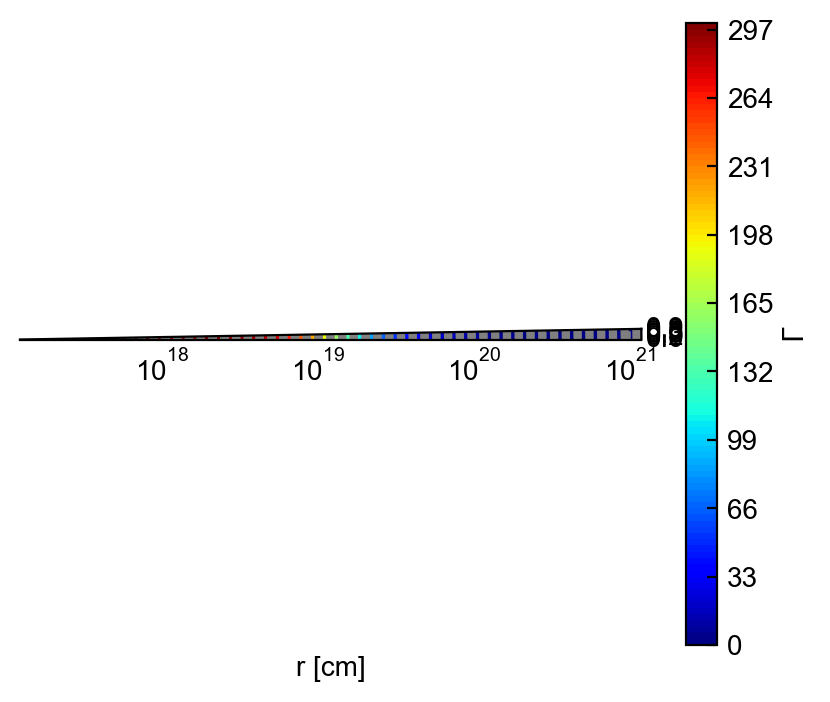

In [68]:
def show_dynamics(r_name, theta_name):
    r1d = np.loadtxt(r_name) * 1.5e13
    theta1d = np.loadtxt(theta_name)

    r, theta = np.meshgrid(r1d, theta1d)
    
    gamma = np.loadtxt(prefix+'Gamma.txt')

    fig = plt.figure(figsize=(4.8, 3.6))

    ax1 = fig.add_subplot(1,1,1,projection='polar')
    cs = ax1.contourf(theta, r, (gamma), levels=100, cmap = 'jet')
    ax1.set_xlim(0, theta1d[-1])
    ax1.set_xlabel('r [cm]')
    cbar =plt.colorbar(cs)
    cbar.set_label(r'$\Gamma$')
    ax1.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(prefix+'gamma.png', dpi=300, bbox_inches='tight')

show_dynamics(prefix+'r.txt', prefix+'theta.txt')

In [99]:
def show_syn_nv(r_name, theta_name, x,zoom):
    r1d = np.loadtxt(r_name) * 1.5e13
    theta1d = np.loadtxt(theta_name)*zoom

    r, theta = np.meshgrid(r1d, theta1d)
    
    nu_m = np.loadtxt(prefix+'syn'+x+'_nu_m.txt')/500
    nu_c = np.loadtxt(prefix+'syn'+x+'_nu_c.txt')/500
    nu_a = np.loadtxt(prefix+'syn'+x+'_nu_a.txt')/500
    nu_p = np.loadtxt(prefix+'syn'+x+'_nu_E_peak.txt')/500
    Y = np.loadtxt(prefix+'Y'+x+'.txt')
    fig = plt.figure(figsize=(3*4.8, 2*3.6))

    min_nu = min(nu_m.min(),nu_c.min(),nu_a.min())
    max_nu = max(nu_m.max(),nu_c.max(),nu_a.max())

    axs = [ fig.add_subplot(2,3,i+1,projection='polar') for i in range(6)]
    for ax, nu, name in zip(axs, [nu_m, nu_c, nu_a, nu_p], ['\\nu^\\prime_m', '\\nu^\\prime_c', '\\nu^\\prime_a', '\\nu^\\prime_{peak}']):
        lv = np.linspace(np.log10(min_nu),np.log10(max_nu),100)
        cs = ax.contourf(theta, r, np.log10(nu), levels=100, cmap = 'jet',extend='both')
        ax.set_xlim(0, theta1d[-1])
        ax.set_xlabel('r [cm]')
        cbar =plt.colorbar(cs)
        cbar.set_label(r'$\log_{10}('+name+'/Hz)$')
        ax.set_yscale('log')
        ax.set_title('$'+name+'$')

    I = (nu_a < nu_m) & (nu_m < nu_c)
    II = (nu_m < nu_a) & (nu_a < nu_c)
    III = (nu_a < nu_c) & (nu_c < nu_m)
    IV = (nu_c < nu_a) & (nu_a < nu_m)
    V = (nu_m < nu_c) & (nu_c < nu_a)
    VI = (nu_c < nu_m) & (nu_m < nu_a)
    regime = np.zeros_like(nu_m)
    regime[I] = 1
    regime[II] = 2
    regime[III] = 3
    regime[IV] = 4
    regime[V] = 5
    regime[VI] = 6

    print(np.unique(regime))

    ax = axs[4]
    
    cs = ax.contourf(theta, r, regime, levels=[0.5,1.5,2.5,3.5,4.5,5.5,6.5], cmap = 'rainbow')
    ax.set_xlim(0, theta1d[-1])
    ax.set_xlabel('r [cm]')
    cbar =plt.colorbar(cs, ticks=[1,2,3,4,5,6])
    cbar.ax.set_yticklabels(['I (a,m,c)', 'II (m,a,c)', 'III (a,c,m)','IV (c,a,m)','V (m,c,a)','VI (c,m,a)']) 
    ax.set_yscale('log')

    ax = axs[5]

    #cs = ax.contourf(theta, r, Y, levels=np.logspace(-3,1,100), cmap = 'rainbow',norm = mpl.colors.LogNorm(),extend='both')
    cs = ax.contourf(theta, r, Y, levels=100, cmap = 'rainbow')
    ax.set_xlim(0, theta1d[-1])
    ax.set_xlabel('r [cm]')
    #cbar =plt.colorbar(cs,ticks=[1e-3,1e-2,1e-1,1e0,1e1,1e2])
    cbar =plt.colorbar(cs)
    cbar.set_label(r'$\hat{Y}$')
    ax.set_yscale('log')
    ax.set_title('$\hat{Y}$')

    plt.tight_layout()
    plt.savefig(prefix+x+'nu.png', dpi=300, bbox_inches='tight')




[1. 2. 3. 4.]


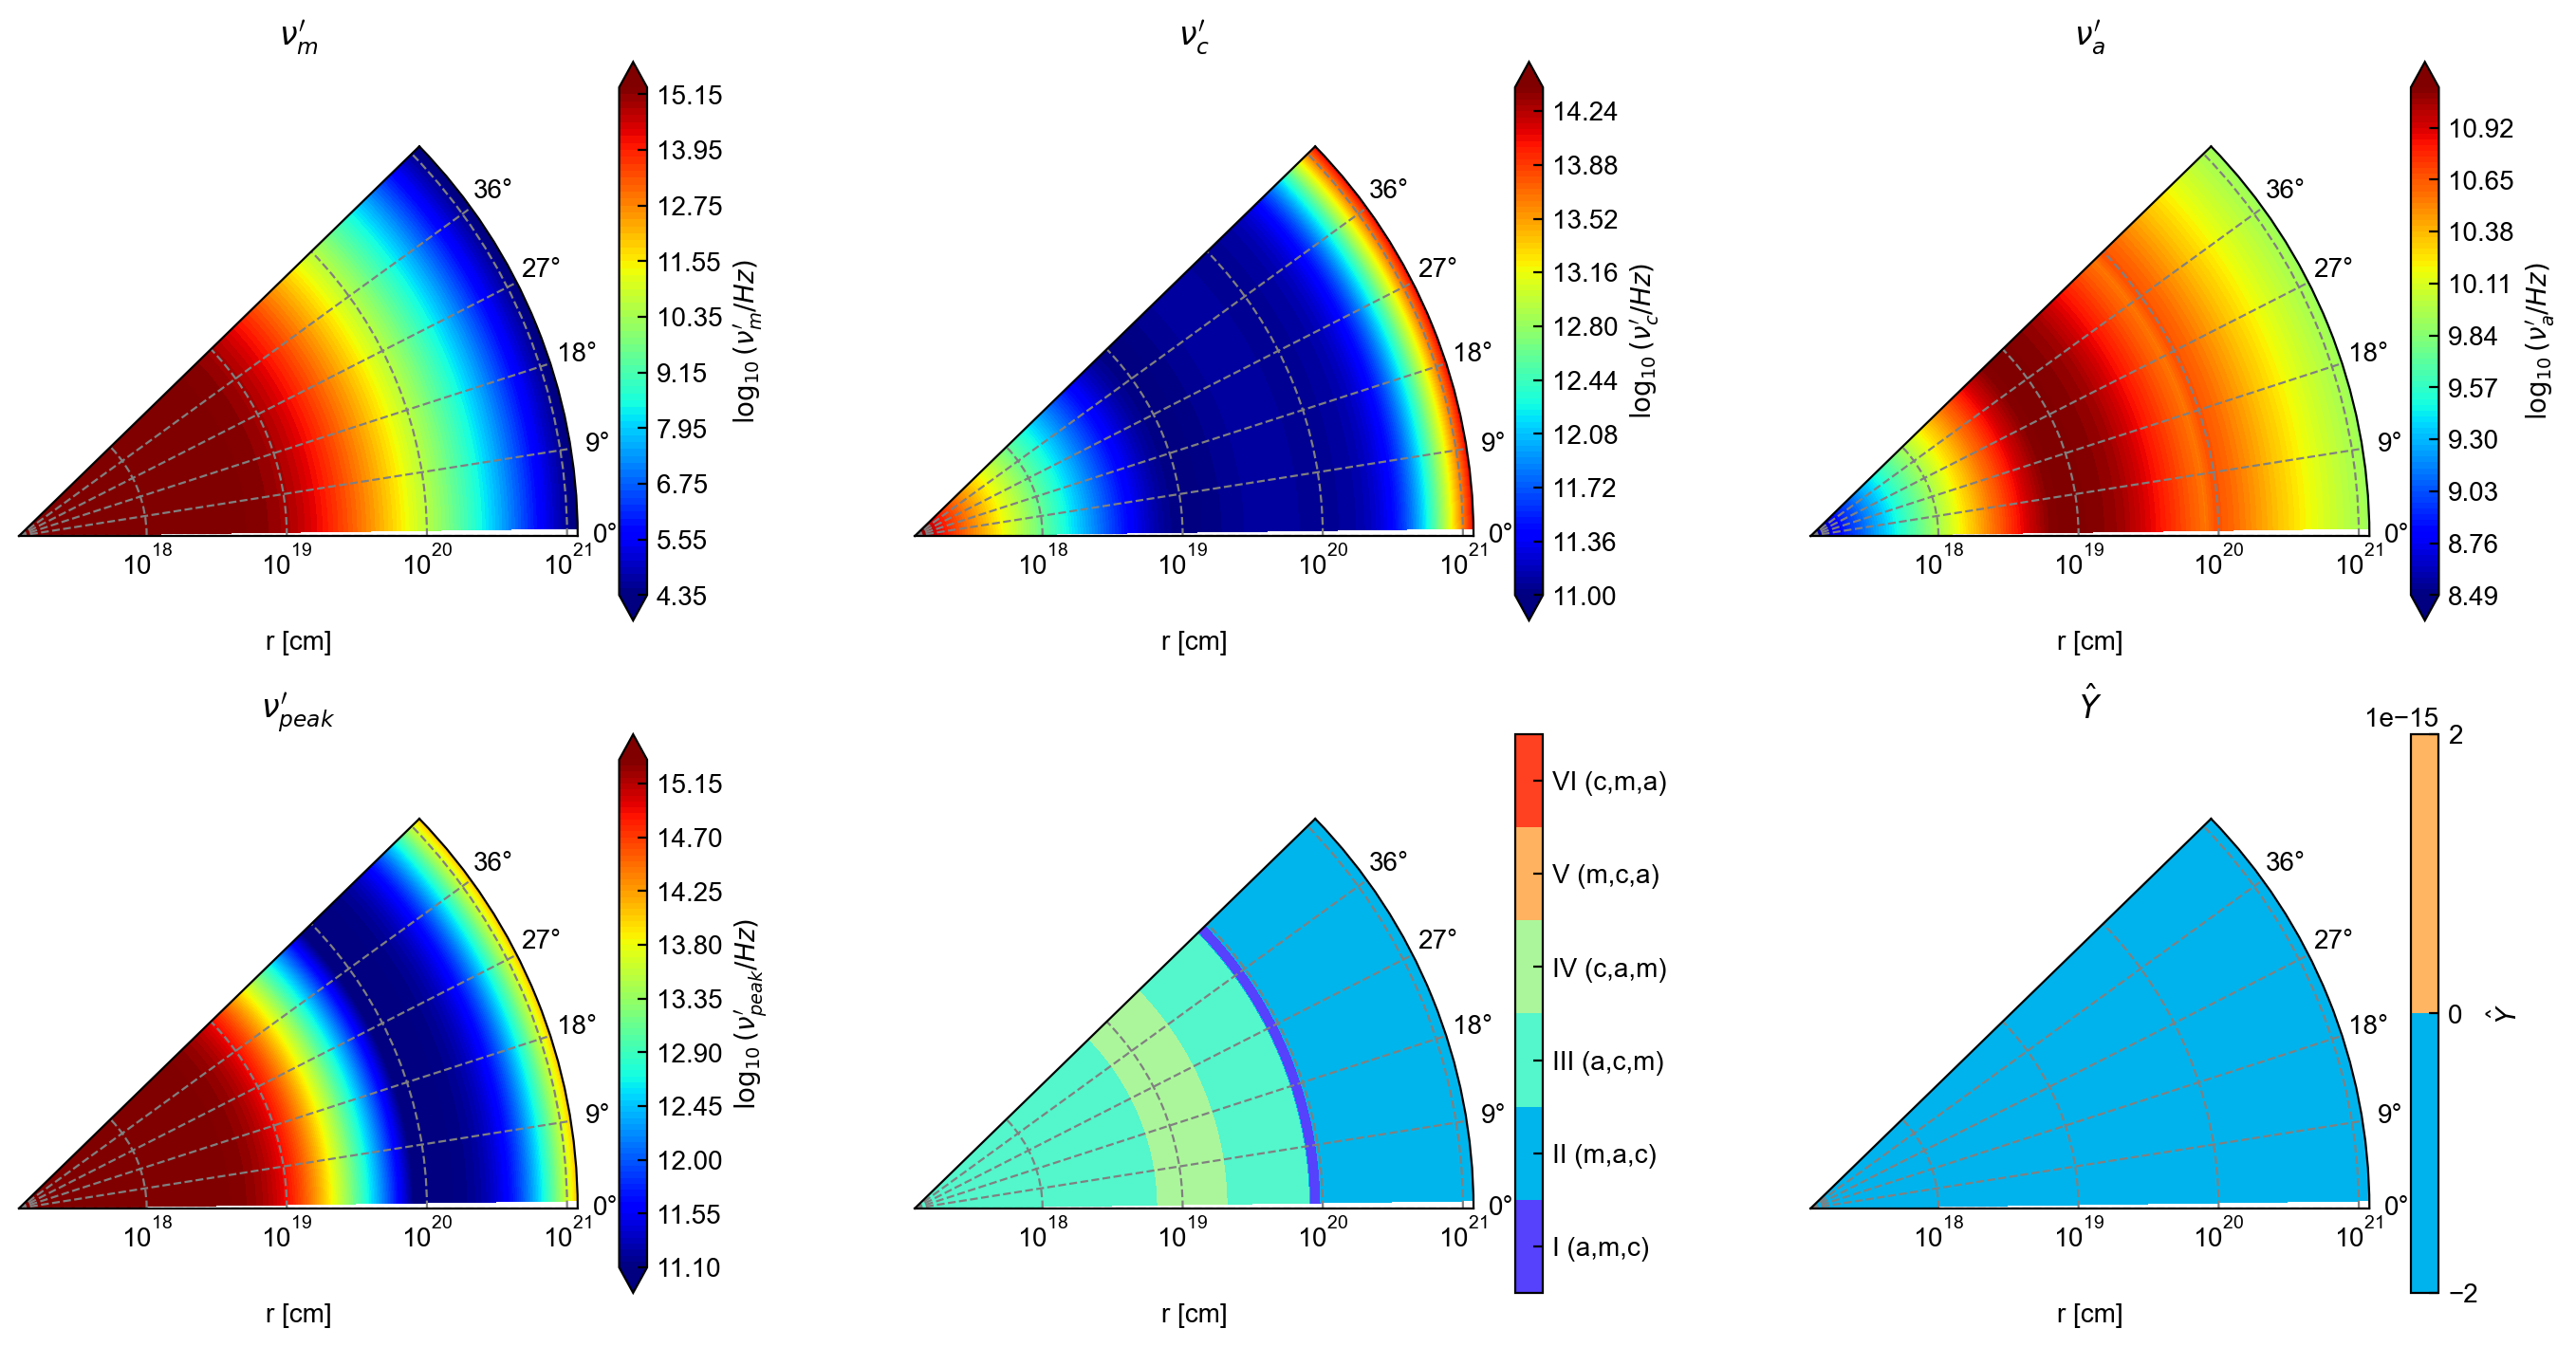

In [100]:
show_syn_nv(prefix+'r.txt', prefix+'theta.txt','',45)

[2. 3. 4. 5. 6.]


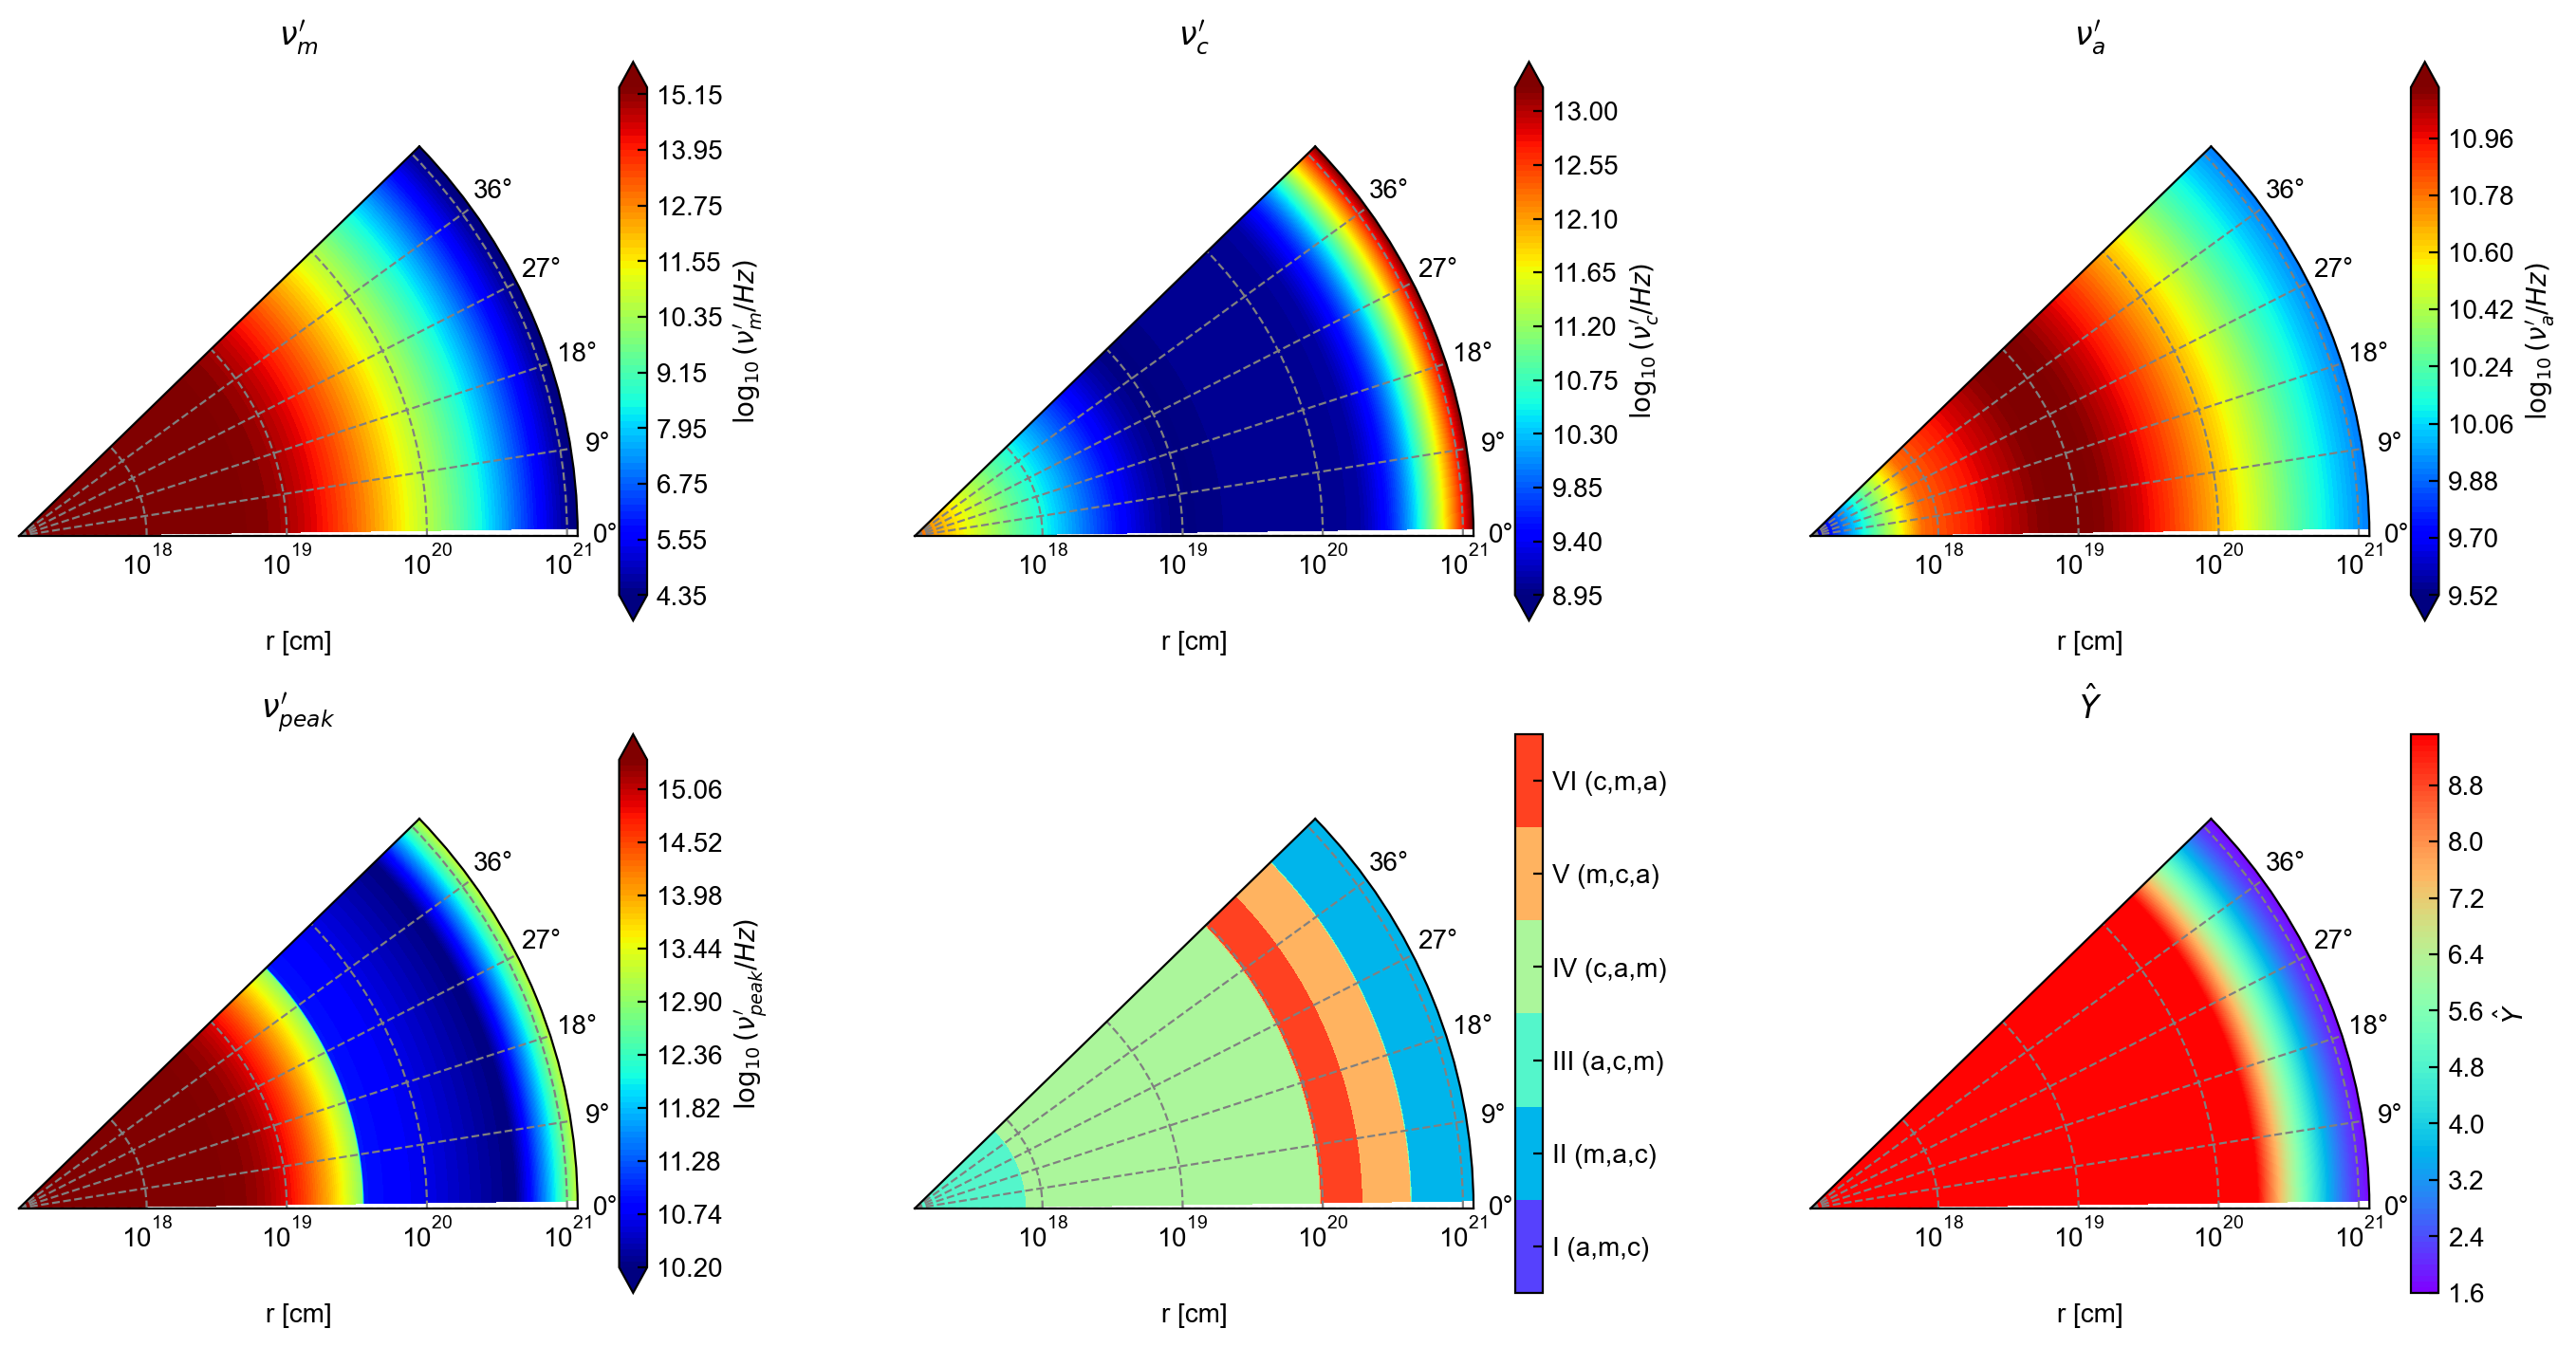

In [101]:
show_syn_nv(prefix+'r.txt', prefix+'theta.txt','_IC',45)

[2. 3. 4. 5. 6.]


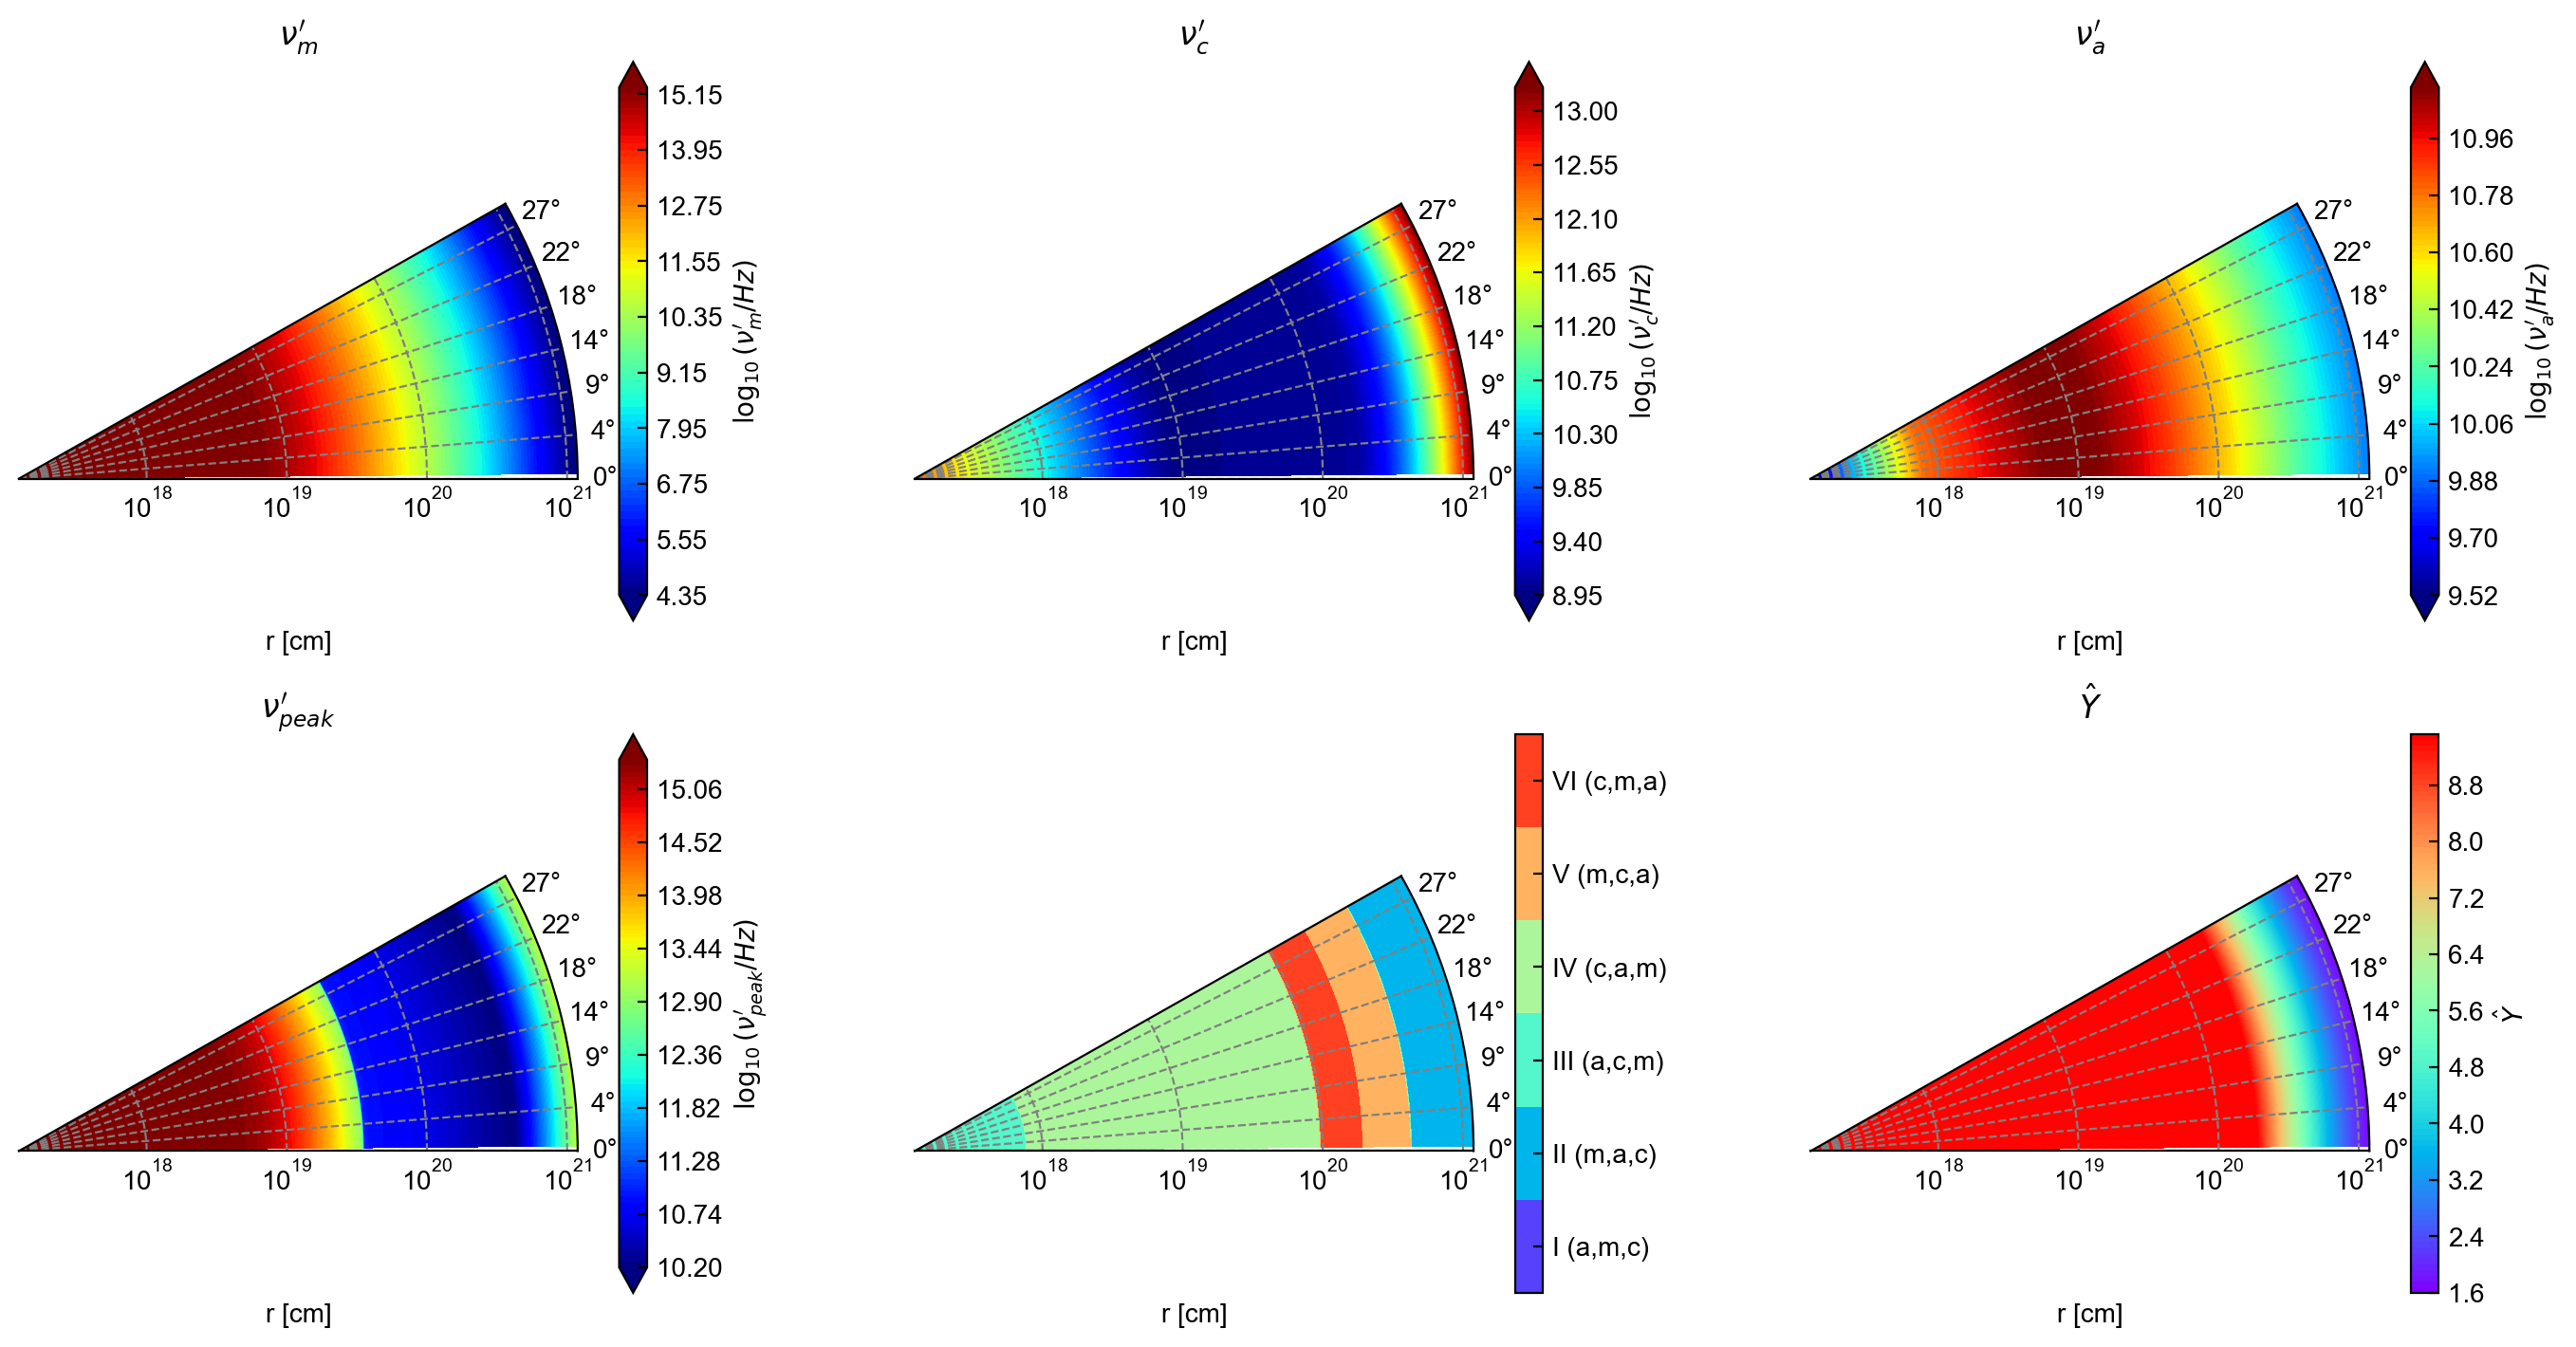

In [80]:
show_syn_nv(prefix+'r.txt', prefix+'theta.txt','_ICKN',30)

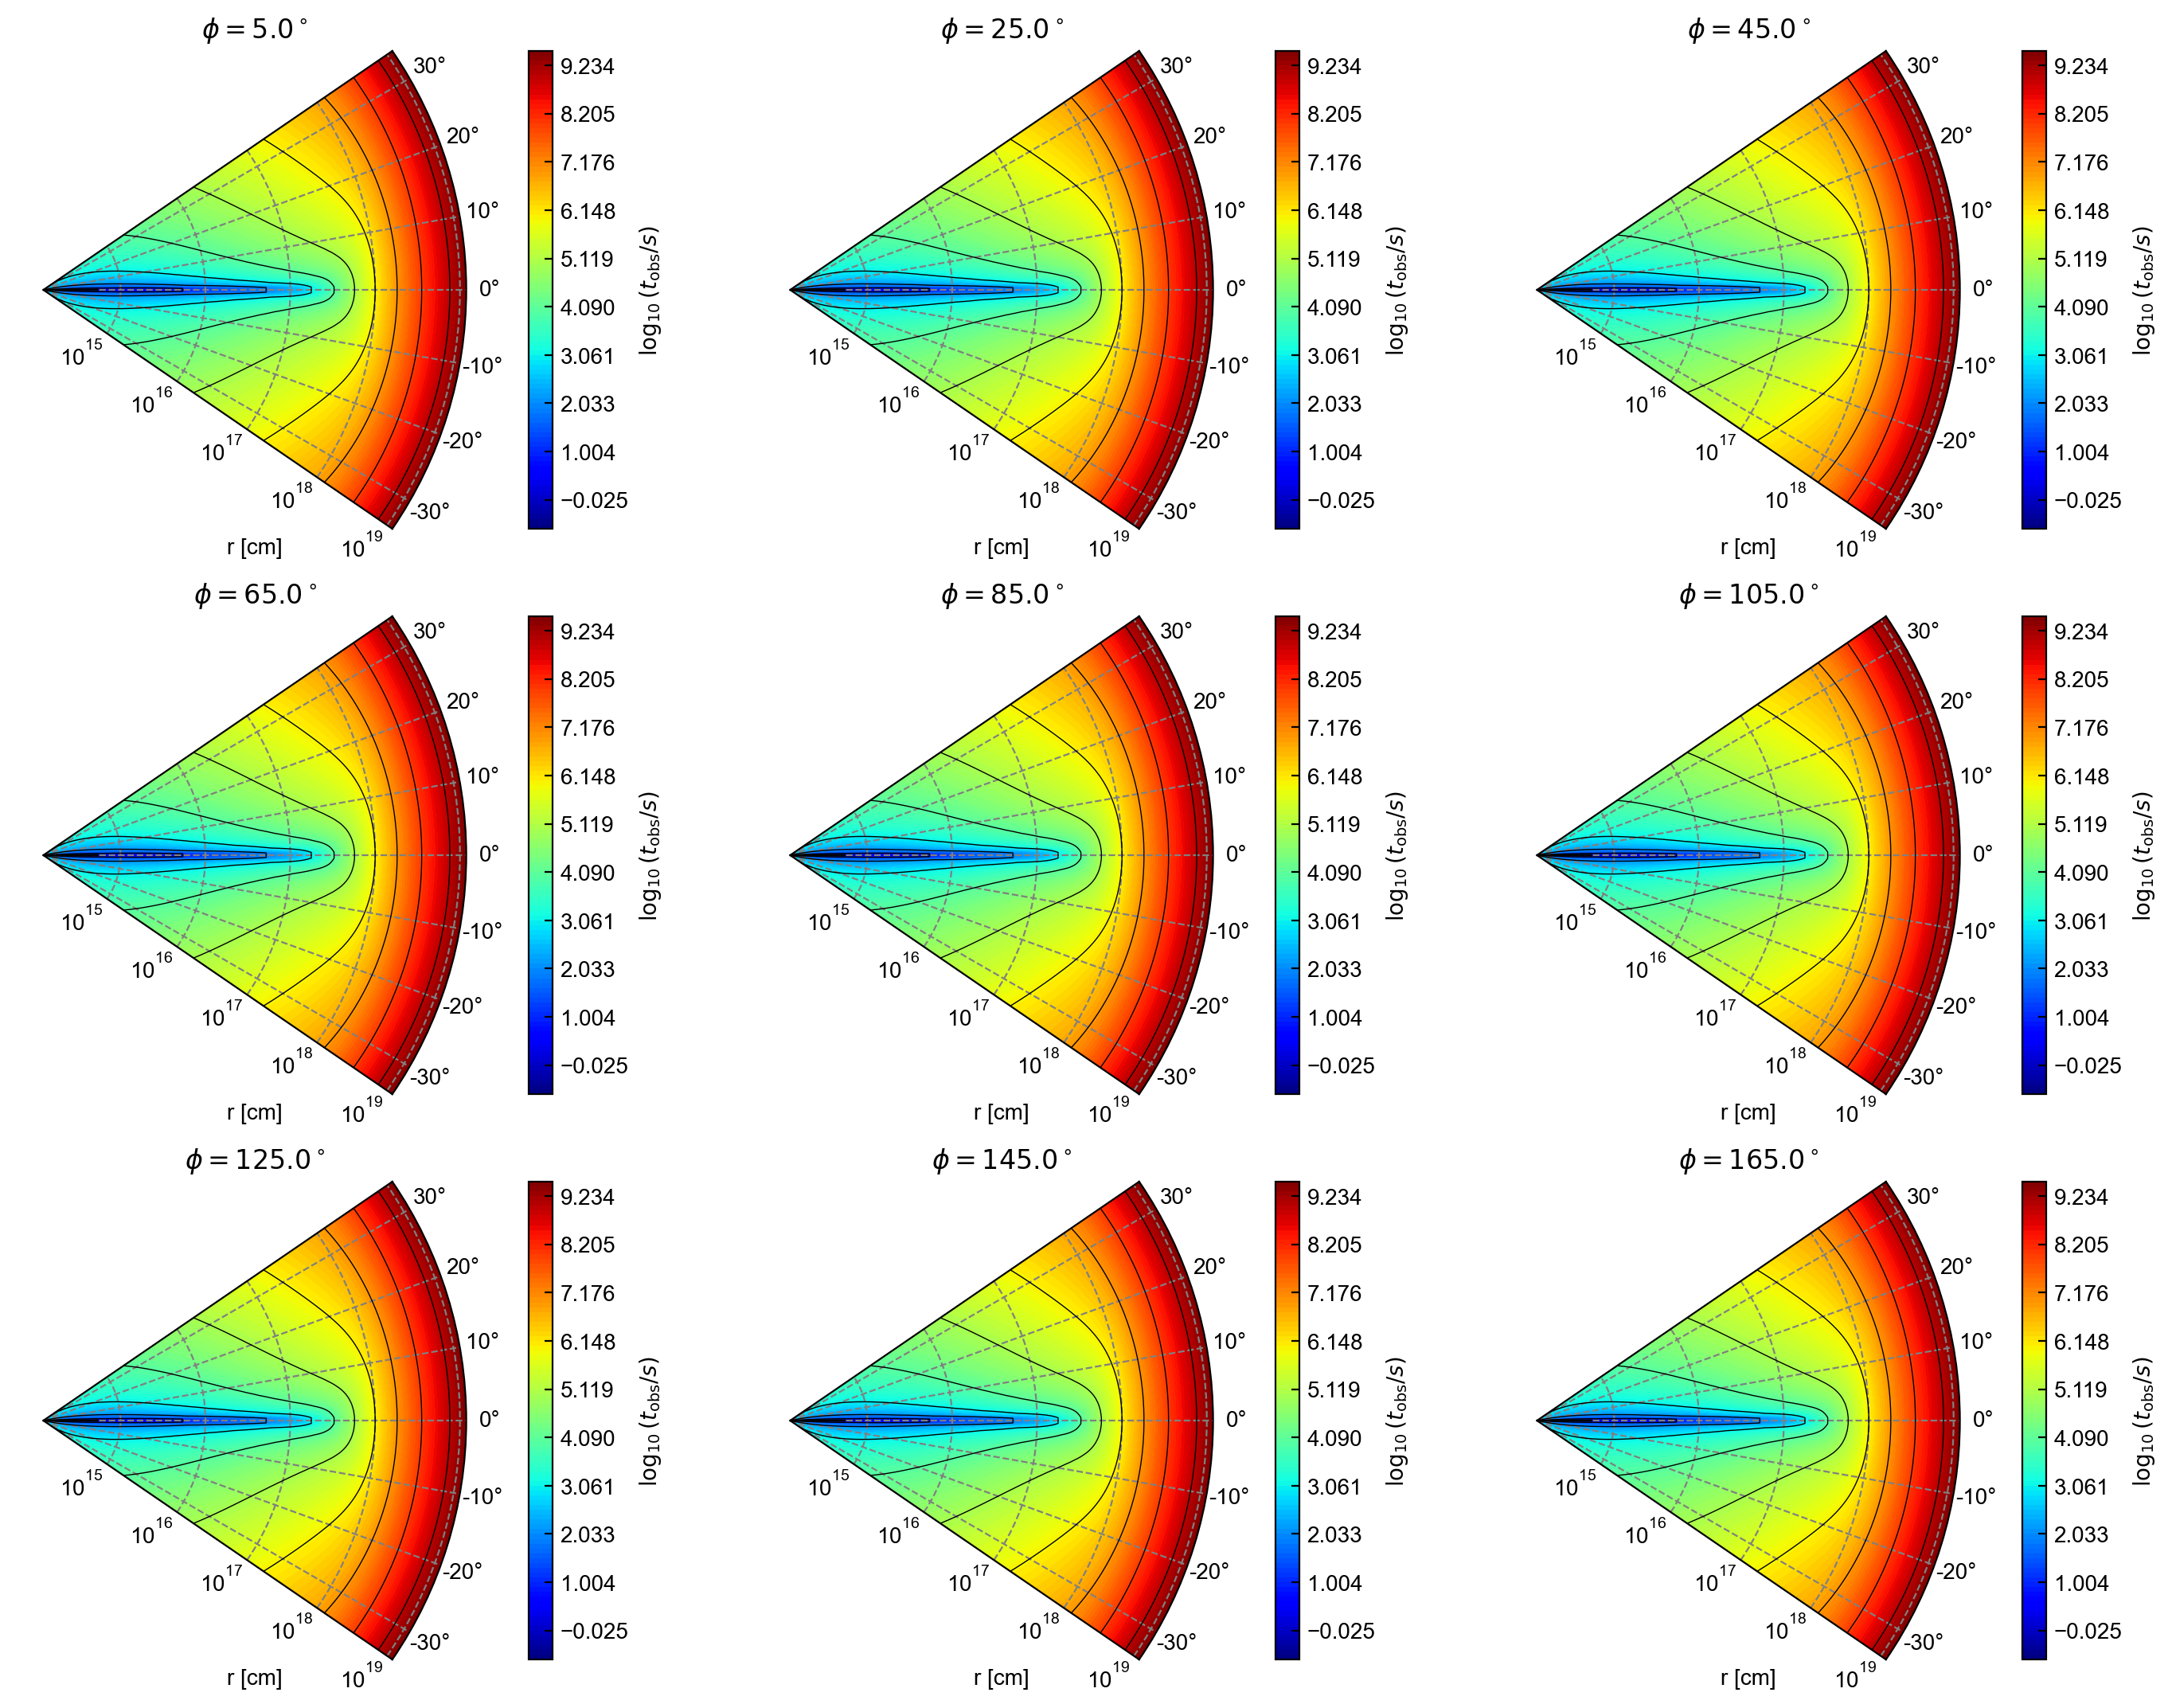

In [51]:
def draw_t_obs(r_name, theta_name, phi_name, var_name):
    r1d = np.loadtxt(r_name) * 1.5e13
    theta1d = np.loadtxt(theta_name)
    phi1d = np.loadtxt(phi_name)

    d = np.loadtxt(var_name)*500

    theta_ext = np.hstack([-theta1d[::-1], theta1d])

    fig = plt.figure(figsize=(4.8*3, 3.6*3))

    axs = [fig.add_subplot(3, 3, i+1,projection='polar') for i in range(int(len(phi1d)/4))]
    
    for i, ax in zip(range(int(len(phi1d)/4)), axs):
        i = i*2
        j = i + int(len(phi1d)/2)
        var1 = d[(j*len(theta1d)):(j+1)*len(theta1d),:]
        var2 = d[(i*len(theta1d)):(i+1)*len(theta1d),:]

        r, theta = np.meshgrid(r1d, theta_ext)

        var1 =np.flip(var1, axis=0)
        var = np.vstack([var1, var2])

        cs = ax.contourf(theta, r, np.log10(var), levels = np.linspace(np.log10(d[d>0]).min(),np.log10(d.max()),100), cmap = 'jet')
        cl=ax.contour(theta, r, np.log10(var), levels = 10, colors = 'black', linewidths = 0.5)

        ax.set_title('$\\phi = {:.1f}^\\circ$'.format(phi1d[i]/np.pi*180))
        ax.set_xlim(-theta1d[-1], theta1d[-1])
        ax.set_xlabel('r [cm]')
        cbar = plt.colorbar(cs)
        cbar.set_label('$\\log_{10}(t_{\\rm obs}/s)$')
        ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig(prefix+'t_obs.png', dpi=300, bbox_inches='tight')
    
draw_t_obs(prefix+'r.txt', prefix+'theta.txt', prefix+'phi.txt', prefix+'t_obs.txt')

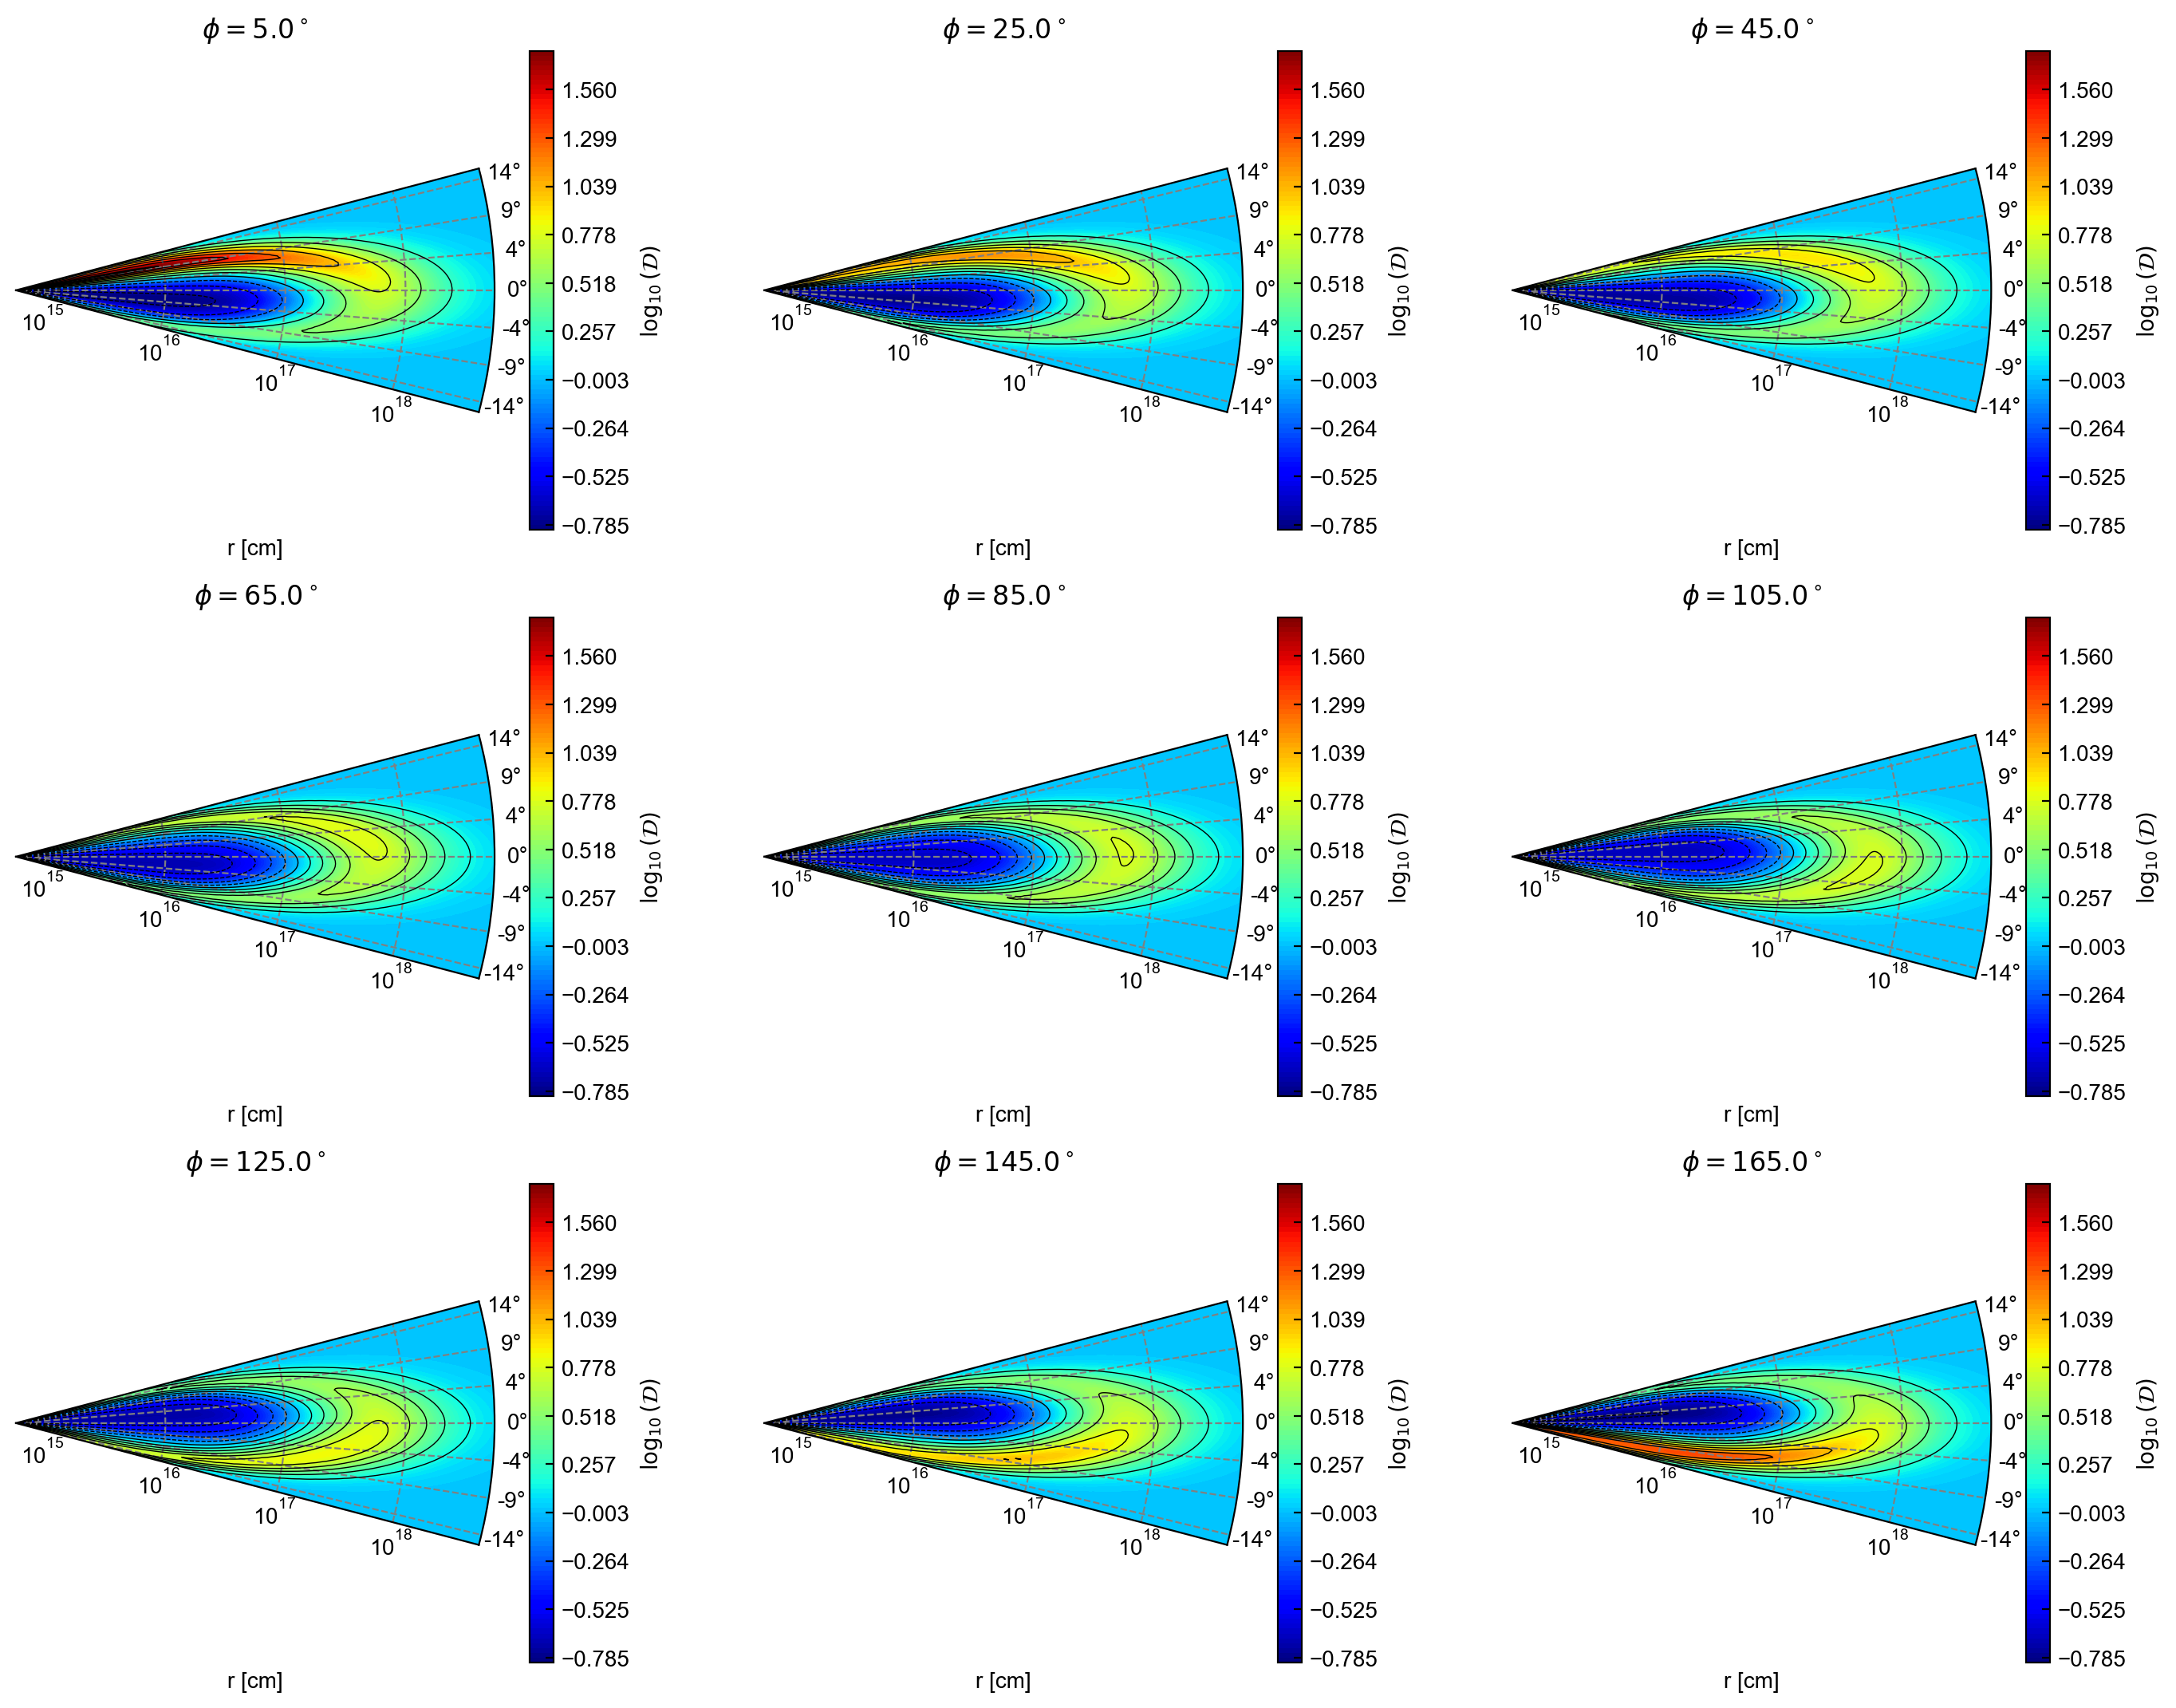

In [22]:
def draw_D(r_name, theta_name, phi_name, var_name):
    r1d = np.loadtxt(r_name) * 1.5e13
    theta1d = np.loadtxt(theta_name)
    phi1d = np.loadtxt(phi_name)

    d = np.loadtxt(var_name)

    theta_ext = np.hstack([-theta1d[::-1], theta1d])

    fig = plt.figure(figsize=(4.8*3, 3.6*3))

    axs = [fig.add_subplot(3, 3, i+1,projection='polar') for i in range(int(len(phi1d)/4))]
    
    for i, ax in zip(range(int(len(phi1d)/4)), axs):
        i = i*2
        j = i + int(len(phi1d)/2)

        var1 = d[(j*len(theta1d)):(j+1)*len(theta1d),:]
        var2 = d[(i*len(theta1d)):(i+1)*len(theta1d),:]

        r, theta = np.meshgrid(r1d, theta_ext)

        var1 =np.flip(var1, axis=0)
        var = np.vstack([var1, var2])

        cs = ax.contourf(theta, r, np.log10(var), levels = np.linspace(np.log10(d[d>0]).min(),np.log10(d.max()),100), cmap = 'jet')
        cl=ax.contour(theta, r, np.log10(var), levels = 10, colors = 'black', linewidths = 0.5)

        ax.set_title('$\\phi = {:.1f}^\\circ$'.format(phi1d[i]/np.pi*180))
        ax.set_xlim(-theta1d[-1], theta1d[-1])
        ax.set_xlabel('r [cm]')
        cbar = plt.colorbar(cs)
        cbar.set_label('$\\log_{10}(\\mathcal{D})$')
        ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig(prefix+'D.png', dpi=300, bbox_inches='tight')
    
draw_D(prefix+'r.txt', prefix+'theta.txt', prefix+'phi.txt', prefix+'doppler.txt')

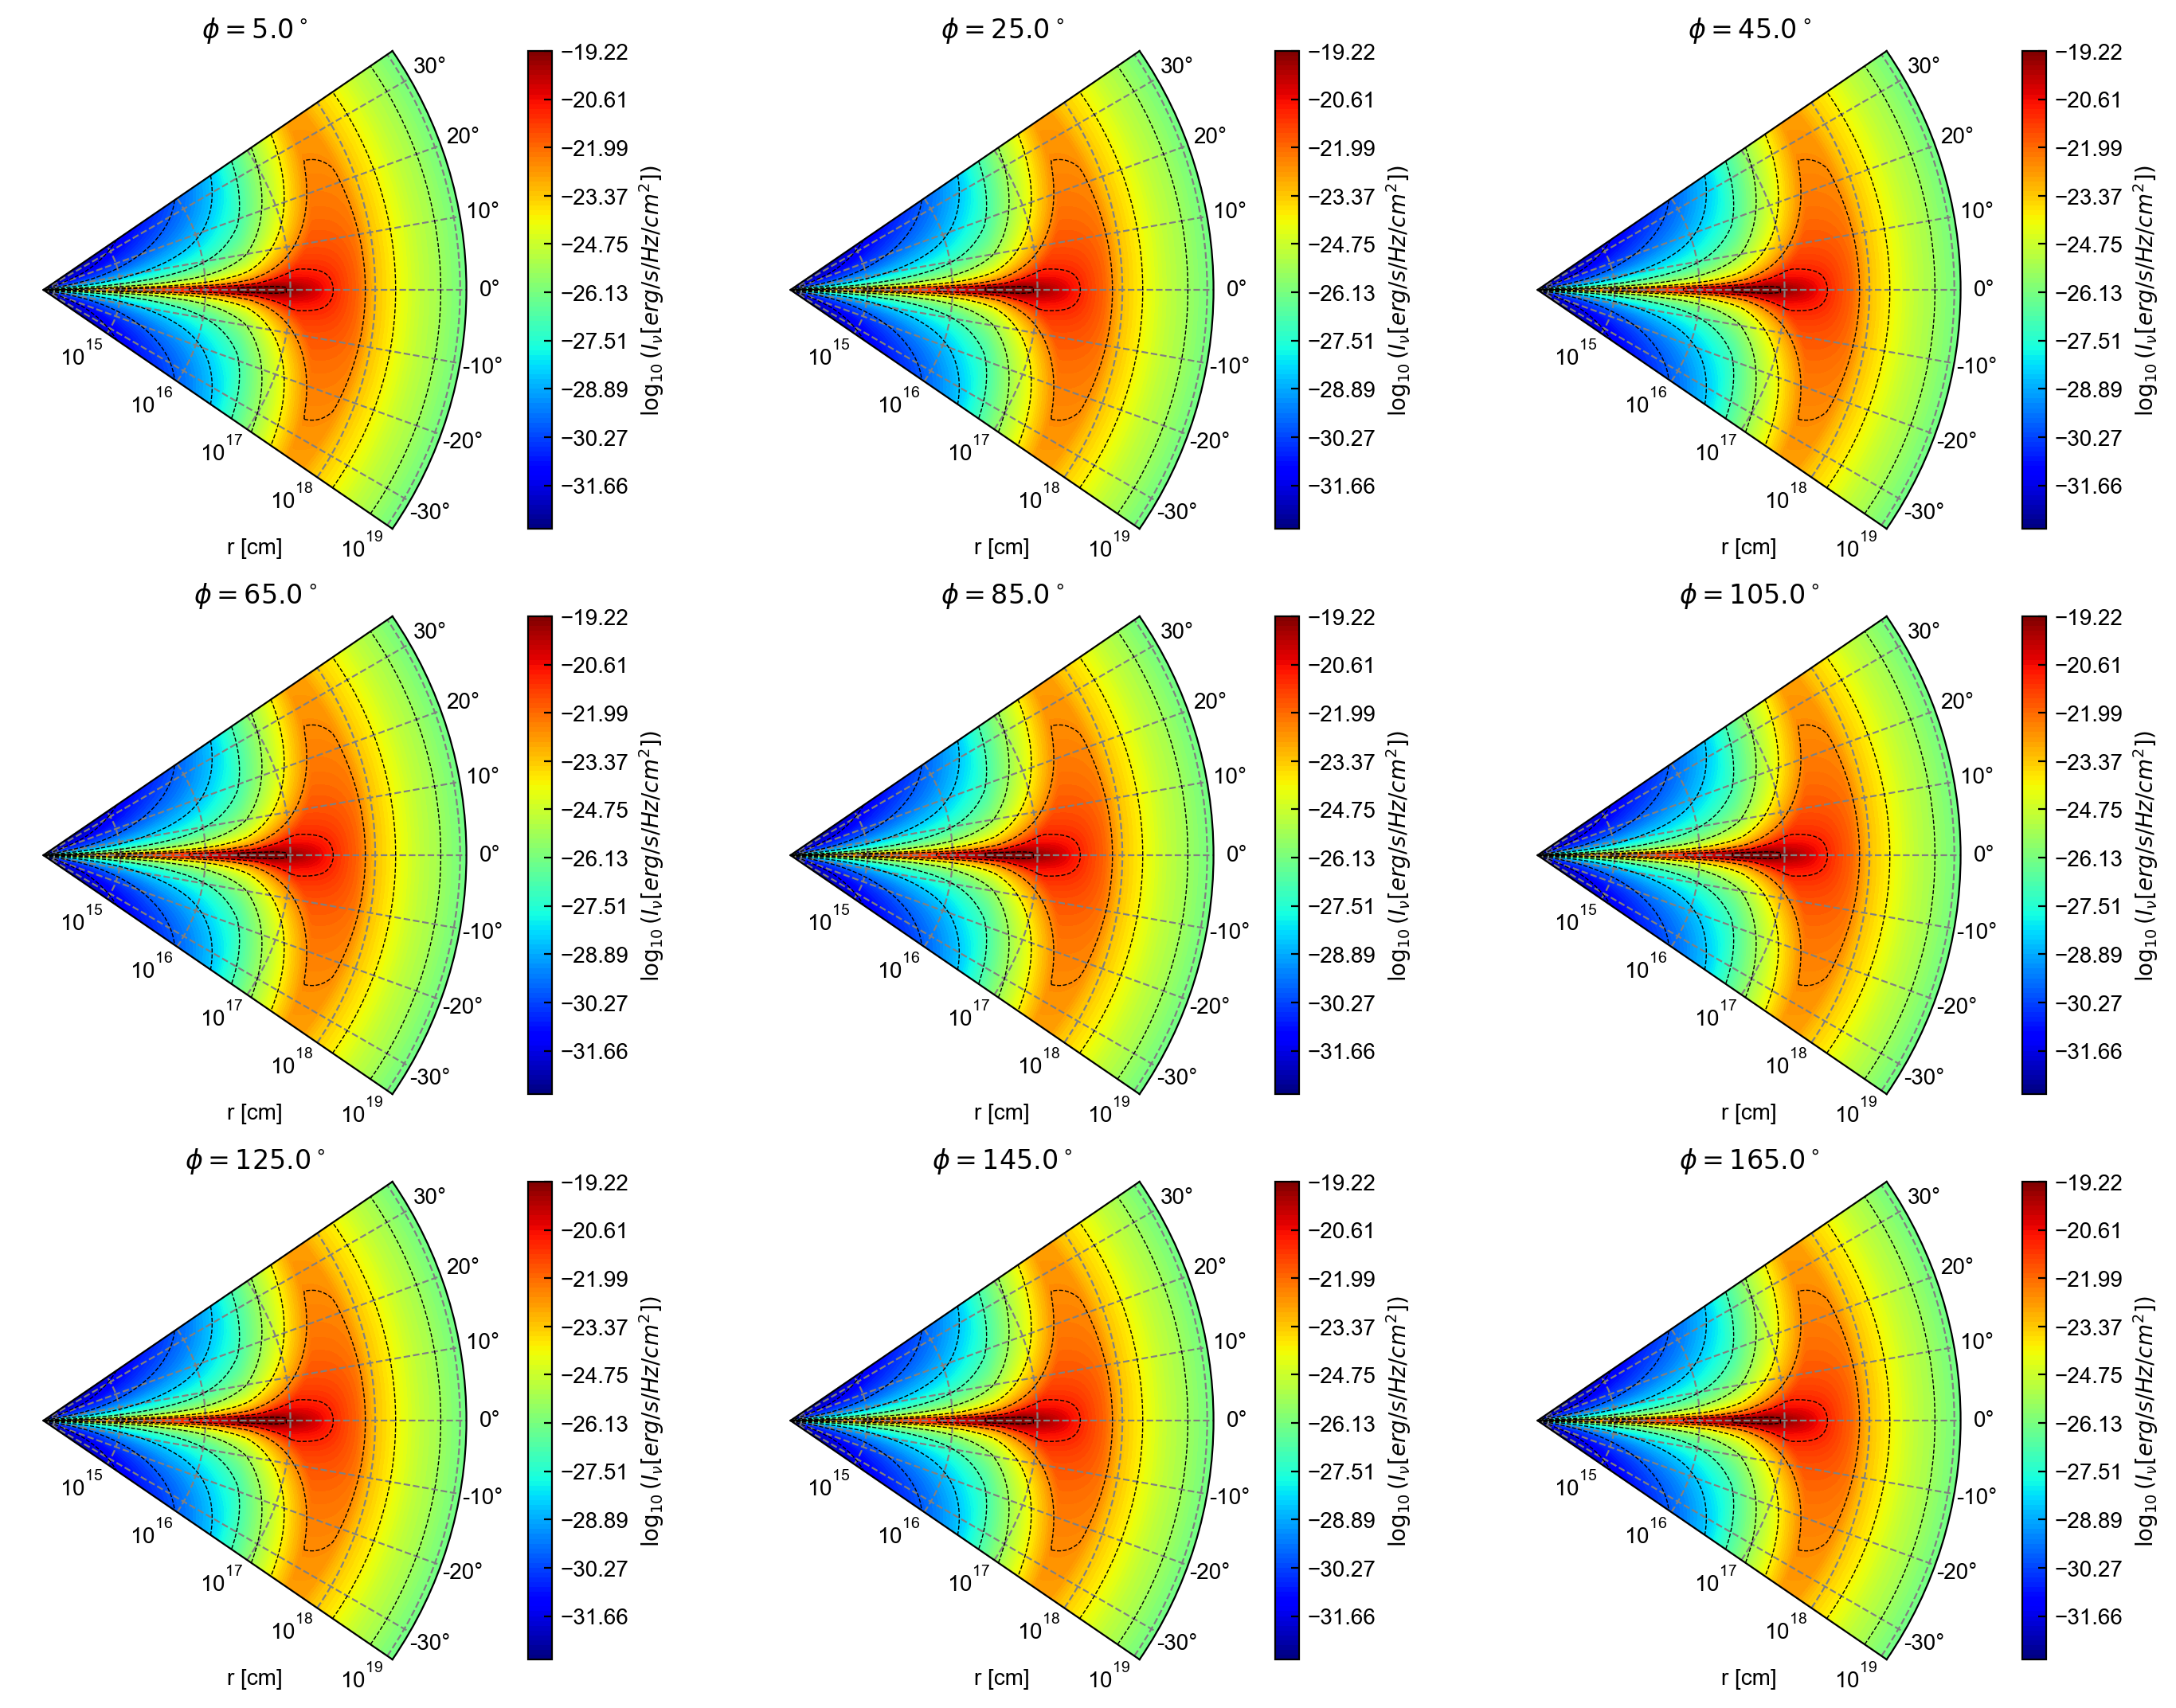

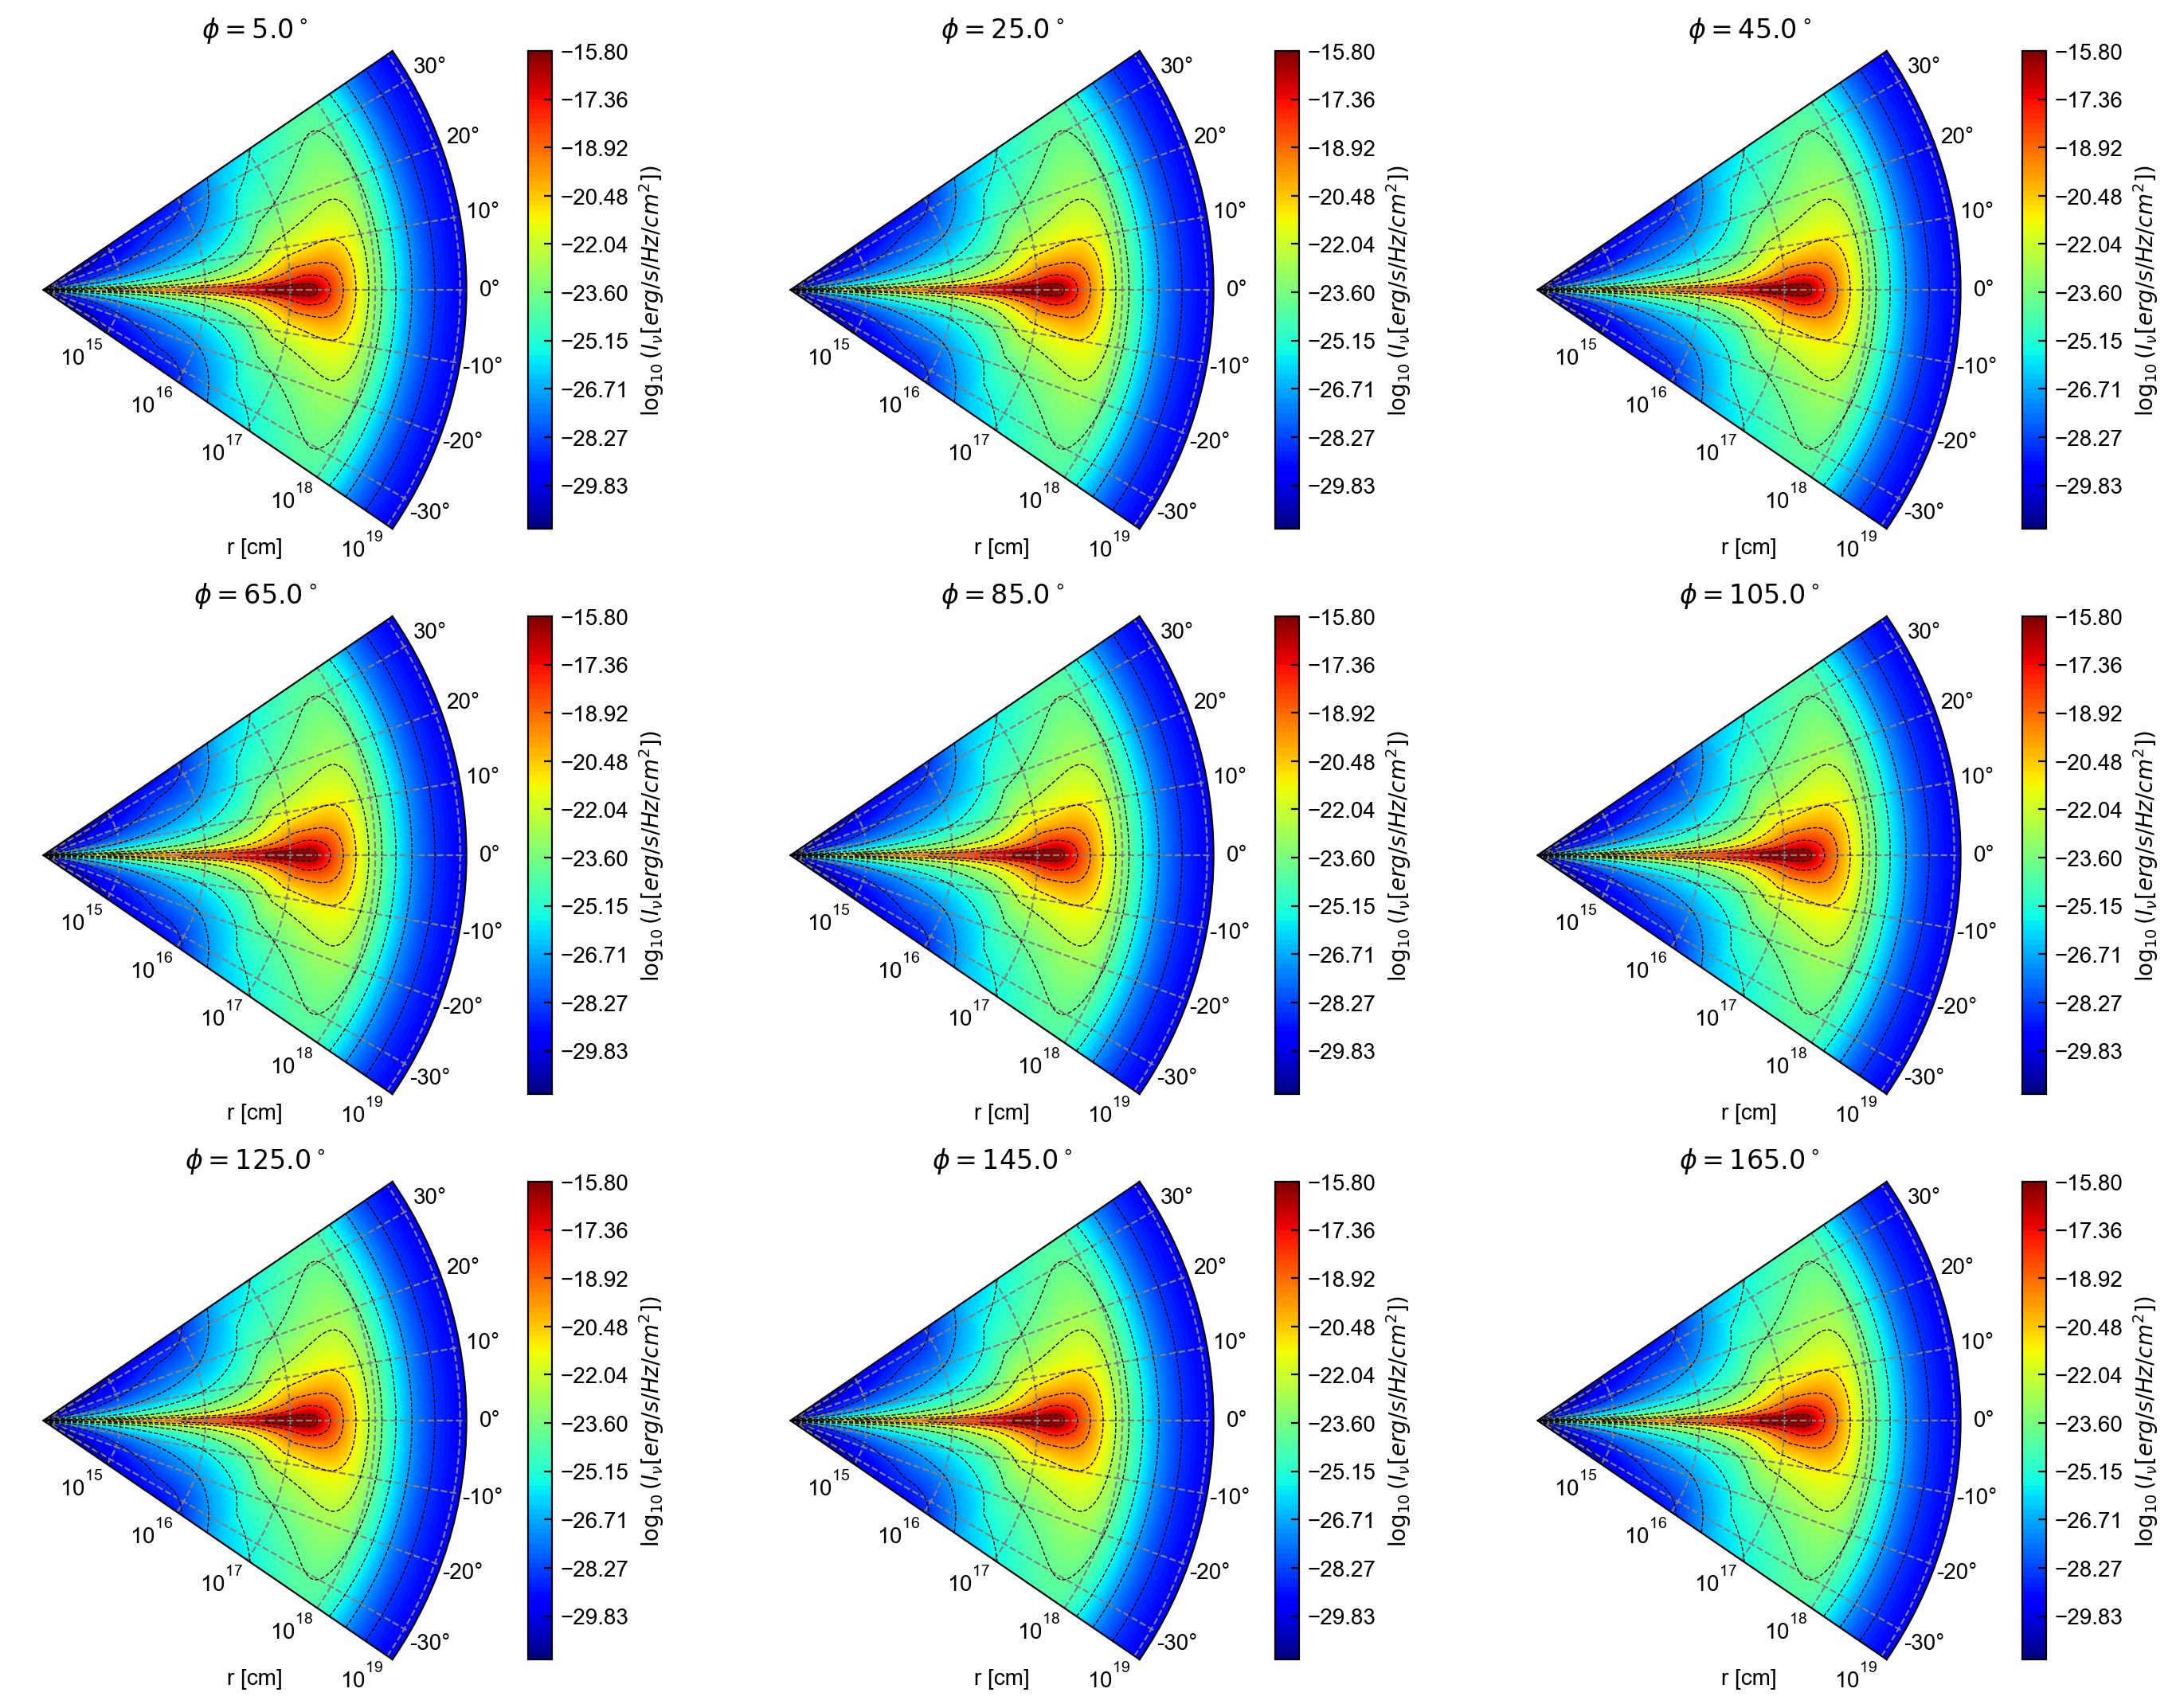

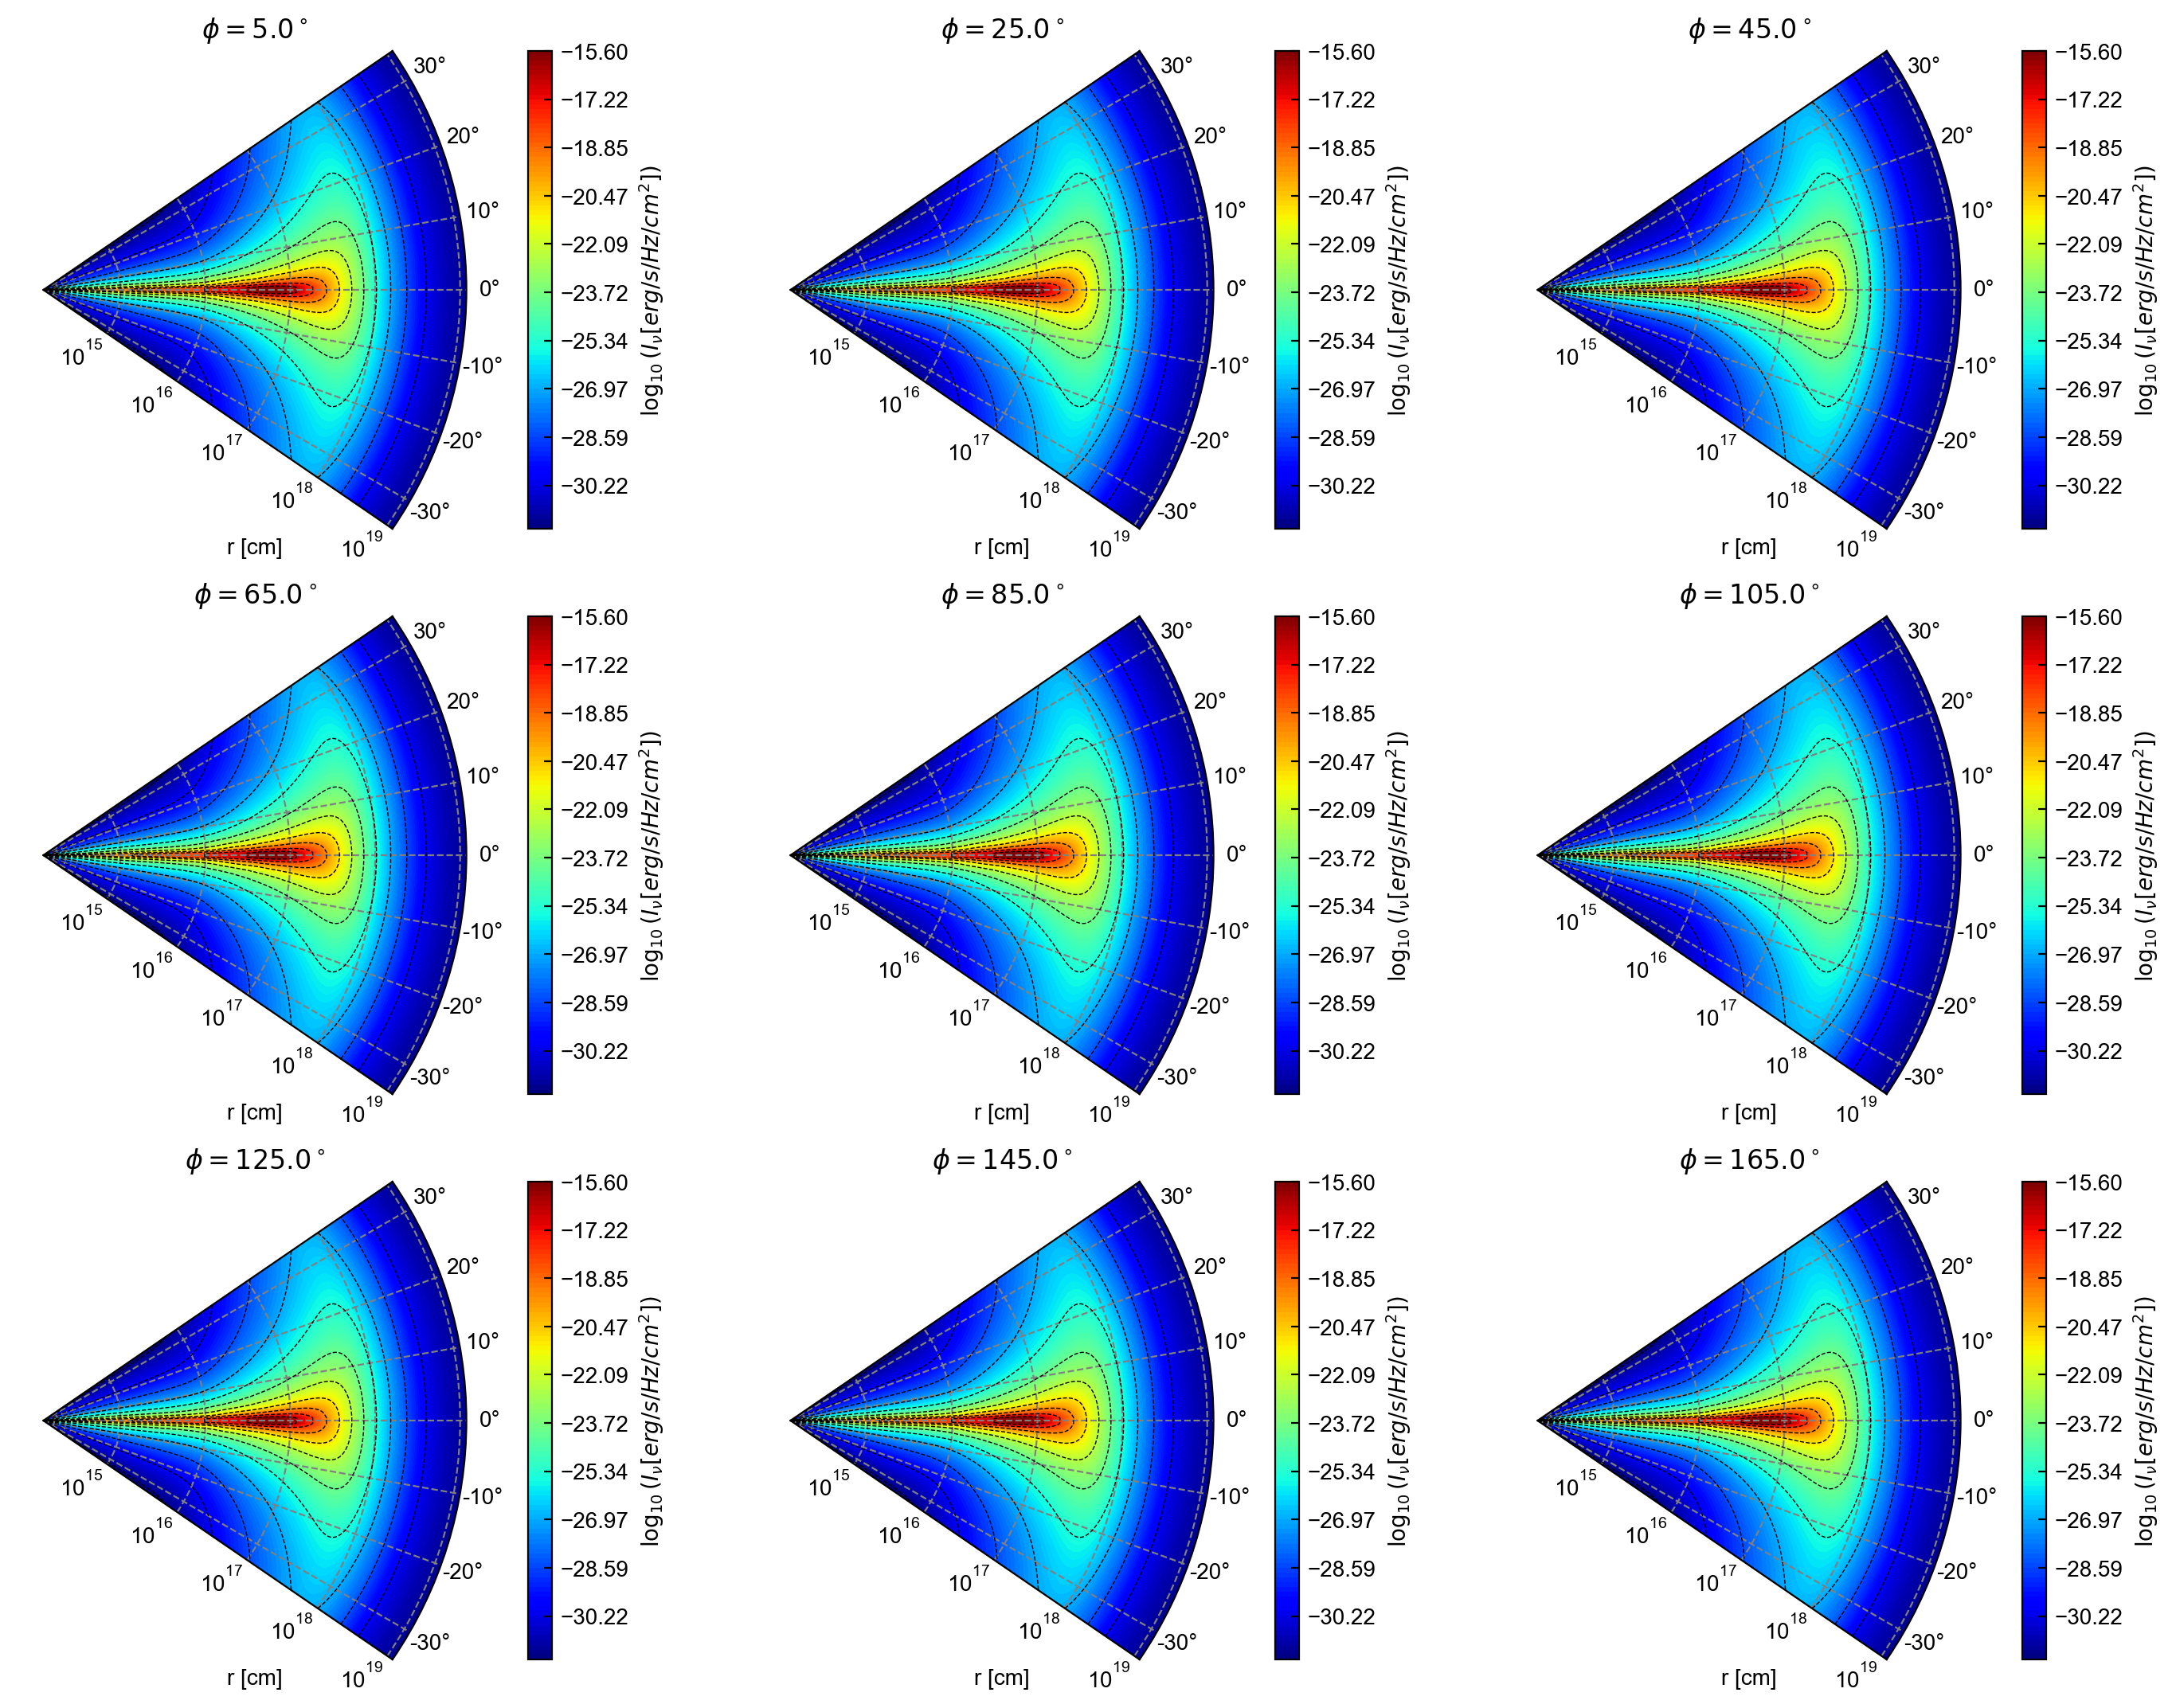

In [50]:
def draw_intensity(r_name, theta_name, phi_name, var_name):
    r1d = np.loadtxt(r_name) * 1.5e13
    theta1d = np.loadtxt(theta_name)
    phi1d = np.loadtxt(phi_name)

    d = np.loadtxt(var_name+'.txt')*2e33*(1.5e13/500)**2/500/(1.5e13)**3

    theta_ext = np.hstack([-theta1d[::-1], theta1d])

    fig = plt.figure(figsize=(4.8*3, 3.6*3))

    axs = [fig.add_subplot(3, 3, i+1,projection='polar') for i in range(int(len(phi1d)/4))]
    
    for i, ax in zip(range(int(len(phi1d)/4)), axs):
        i = i*2
        j = i + int(len(phi1d)/2)
       
        var1 = d[(j*len(theta1d)):(j+1)*len(theta1d),:]
        var2 = d[(i*len(theta1d)):(i+1)*len(theta1d),:]

        r, theta = np.meshgrid(r1d, theta_ext)

        var1 =np.flip(var1, axis=0)
        var = np.vstack([var1, var2])

        cs = ax.contourf(theta, r, np.log10(var), levels = np.linspace(np.log10(d[d>0]).min(),np.log10(d.max()),100), cmap = 'jet')
        cl = ax.contour(theta, r, np.log10(var), levels = 10, colors = 'black', linewidths = 0.5)

        ax.set_title('$\\phi = {:.1f}^\\circ$'.format(phi1d[i]/np.pi*180))
        ax.set_xlim(-theta1d[-1], theta1d[-1])
        ax.set_xlabel('r [cm]')
        cbar = plt.colorbar(cs)
        cbar.set_label('$\\log_{10}(I_\\nu [erg/s/Hz/cm^2])$')
        ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig(var_name+'.png', dpi=300, bbox_inches='tight')
    
draw_intensity(prefix+'r.txt', prefix+'theta.txt', prefix+'phi.txt', prefix+'I_nu_9')
draw_intensity(prefix+'r.txt', prefix+'theta.txt', prefix+'phi.txt', prefix+'I_nu_14')
draw_intensity(prefix+'r.txt', prefix+'theta.txt', prefix+'phi.txt', prefix+'I_nu_17')

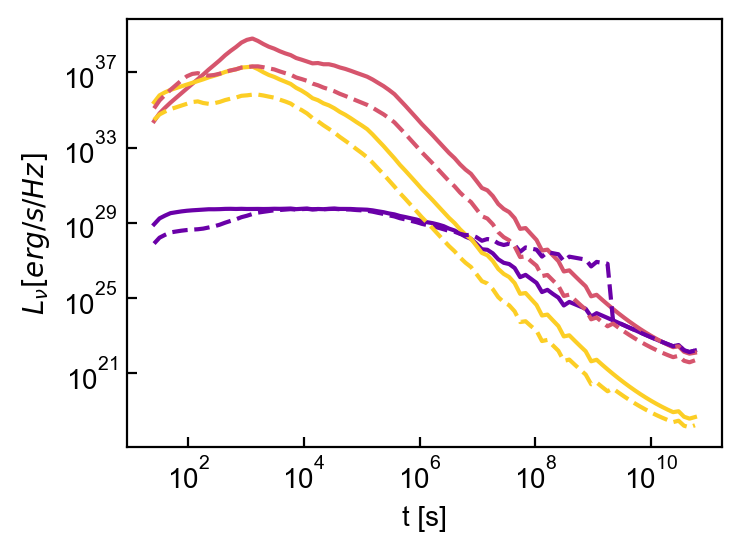

In [79]:
def calc_LC(freqs, names):
    

    colors = cm.plasma(np.linspace(0.2, 0.9, len(freqs)))

    fig = plt.figure(figsize=(4.8*0.8, 3.6*0.8))
    ax = fig.add_subplot(1,1,1)
    ls = ['-', '--', '-.']
    for L_name , l in zip(names, ls):
        for f, c in zip(freqs,colors):
            d = np.loadtxt(prefix+'L_nu'+L_name+'_'+str(f)+'.txt')
            t = d[0,:]*500
            Lnu = d[1,:]*2e33*(1.5e13/500)**2

            ax.plot(t, Lnu,c=c,label = '10$^{'+str(f) + '}$ Hz',ls=l)
       

    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel('t [s]')
    plt.ylabel('$L_{\\nu} [erg/s/Hz]$')
    plt.tight_layout()
    #plt.legend()
    plt.savefig(prefix+'LC.png', dpi=300, bbox_inches='tight')



calc_LC([9,14,17],['','_IC'])

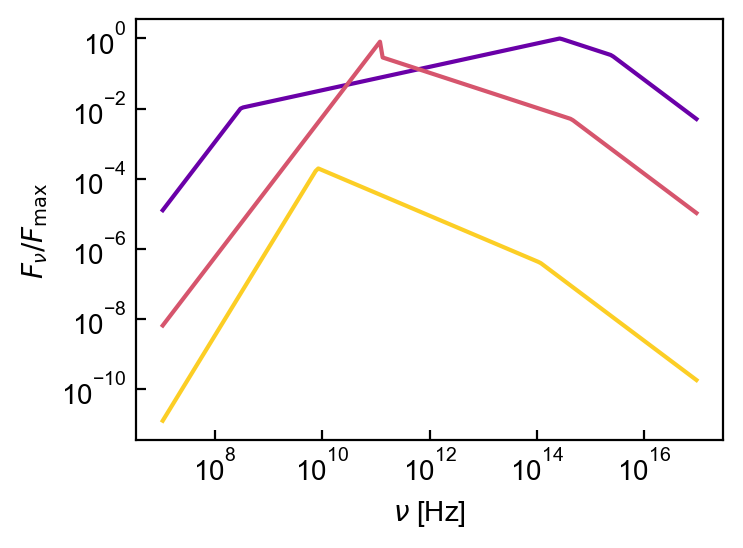

In [90]:
def spectrum(times, names):
    colors = cm.plasma(np.linspace(0.2, 0.9, len(times)))

    fig = plt.figure(figsize=(4.8*0.8, 3.6*0.8))
    ax = fig.add_subplot(1,1,1)
    ls = ['-', '--', '-.']
    for name , l in zip(names, ls):
        for t, c in zip(times,colors):
            d = np.loadtxt(prefix+name+'_spectrum'+str(t)+'.txt')
            t = d[0,:]/500
            Lnu = d[1,:]

            ax.plot(t, Lnu,c=c,label = '10$^{'+str(t) + '}$ Hz',ls=l)
       
    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel(r'$\nu$ [Hz]')
    plt.ylabel('$F_{\\nu}/F_{\\rm max}$')
    plt.tight_layout()
    #plt.legend()
    #plt.savefig(prefix+'LC.png', dpi=300, bbox_inches='tight')

spectrum([0,1,2],['syn'])
    

In [208]:
def full_spectrum(ax, prefix, tname, fname,space, title):
    d = np.loadtxt(prefix+fname)
    t = np.loadtxt(prefix+tname)[0,:]*500
    nu = d[0,:]/500  
    w,h = d.shape
    num = 15
    #colors = cm.plasma(np.linspace(0.1, 0.9, num))
    interval = int((w-1)/num)

    norm = matplotlib.colors.LogNorm(
    vmin=np.min(t),
    vmax=np.max(t))

# choose a colormap
    c_m = matplotlib.cm.plasma

# create a ScalarMappable and initialize a data structure
    s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)

    for i in range(num):
        Lnu = d[i*interval+1,:]/d[i*interval+1,:].max()
        ax.loglog(nu,10**(space*i)* Lnu,c=c_m(norm((t[i*interval]))),lw=1)
        

    ax.set_yticks([])
    cbar = plt.colorbar(s_m,ax=ax)
    cbar.set_label('$t^\prime$ [s]')
    ax.set_xlabel(r'$\nu$ [Hz]')
    ax.set_ylabel('$\\log(F_{\\nu}/F_{\\nu, \\rm max}$)')
    ax.set_title(title)
    
   



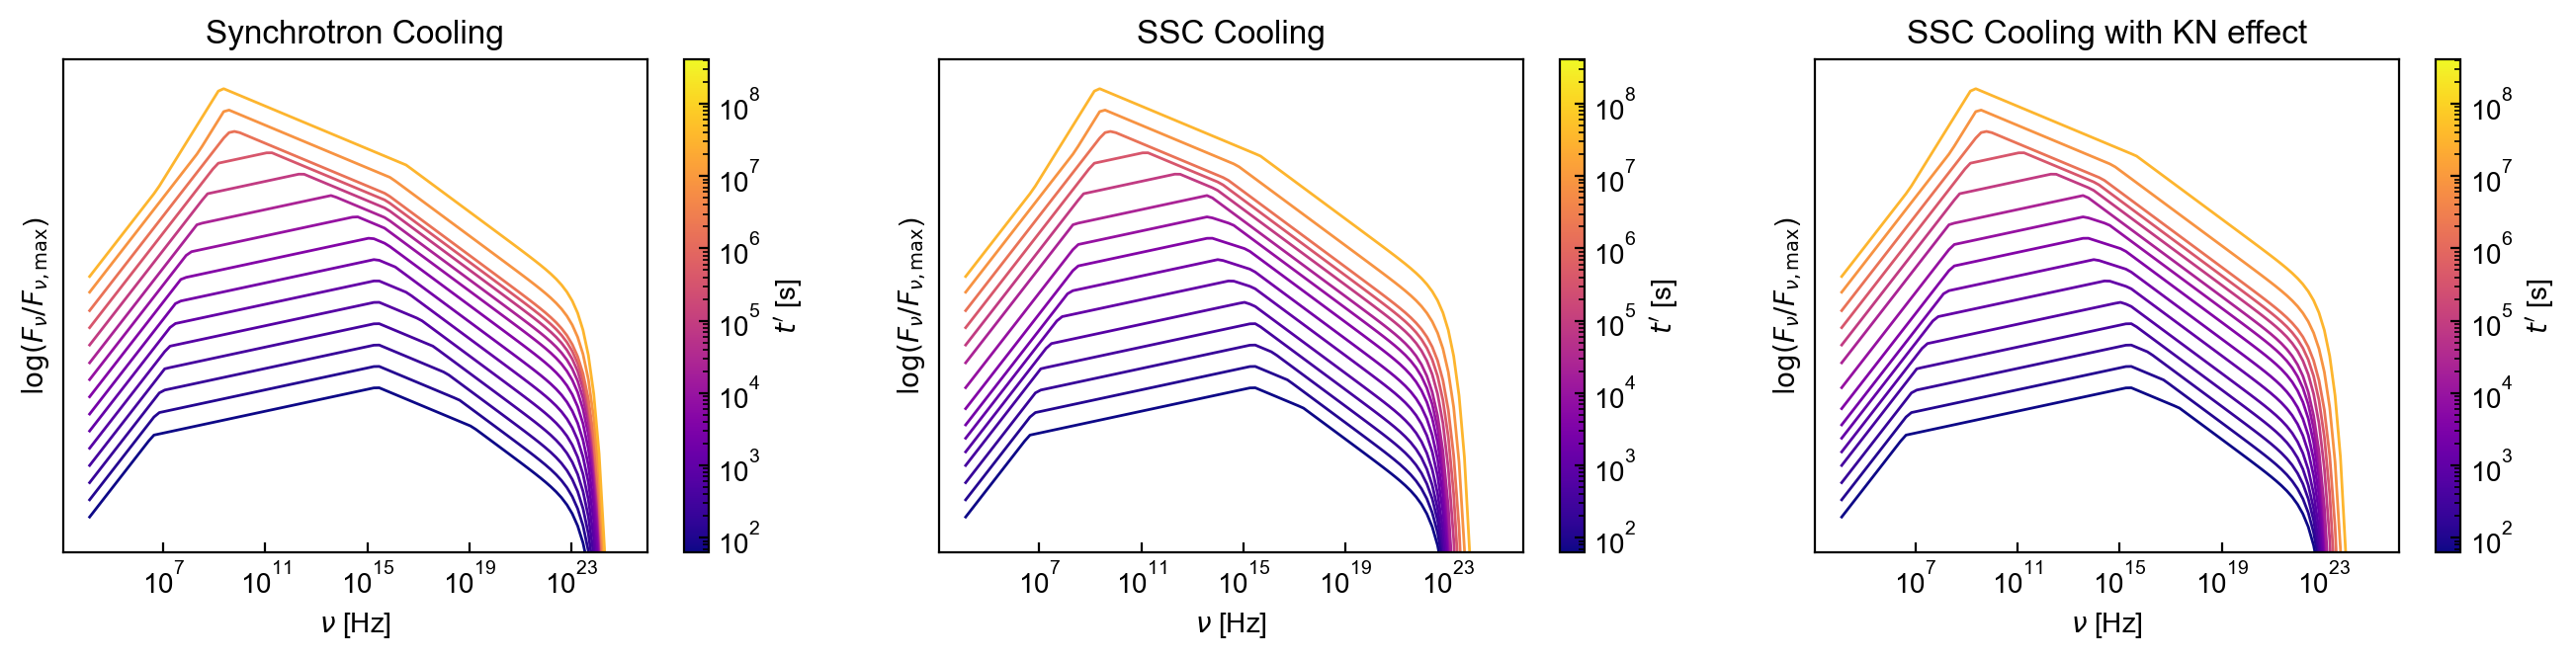

In [217]:
fig = plt.figure(figsize=(6*0.9*3, 3.6*0.9))
ax1 = fig.add_subplot(1,3,1)
full_spectrum(ax1, prefix,'t_com.txt','syn_spectrum.txt',1.3,'Synchrotron Cooling')
ax1.set_ylim(1e-10,1e20)

ax2 = fig.add_subplot(1,3,2)
full_spectrum(ax2, prefix,'t_com.txt','syn_IC_spectrum.txt',1.3,'SSC Cooling')
ax2.set_ylim(1e-10,1e20)

ax2 = fig.add_subplot(1,3,3)
full_spectrum(ax2, prefix,'t_com.txt','syn_ICKN_spectrum.txt',1.3,'SSC Cooling with KN effect')
ax2.set_ylim(1e-10,1e20)

plt.savefig(prefix+'Syn_spectrum.pdf', dpi=300, bbox_inches='tight')

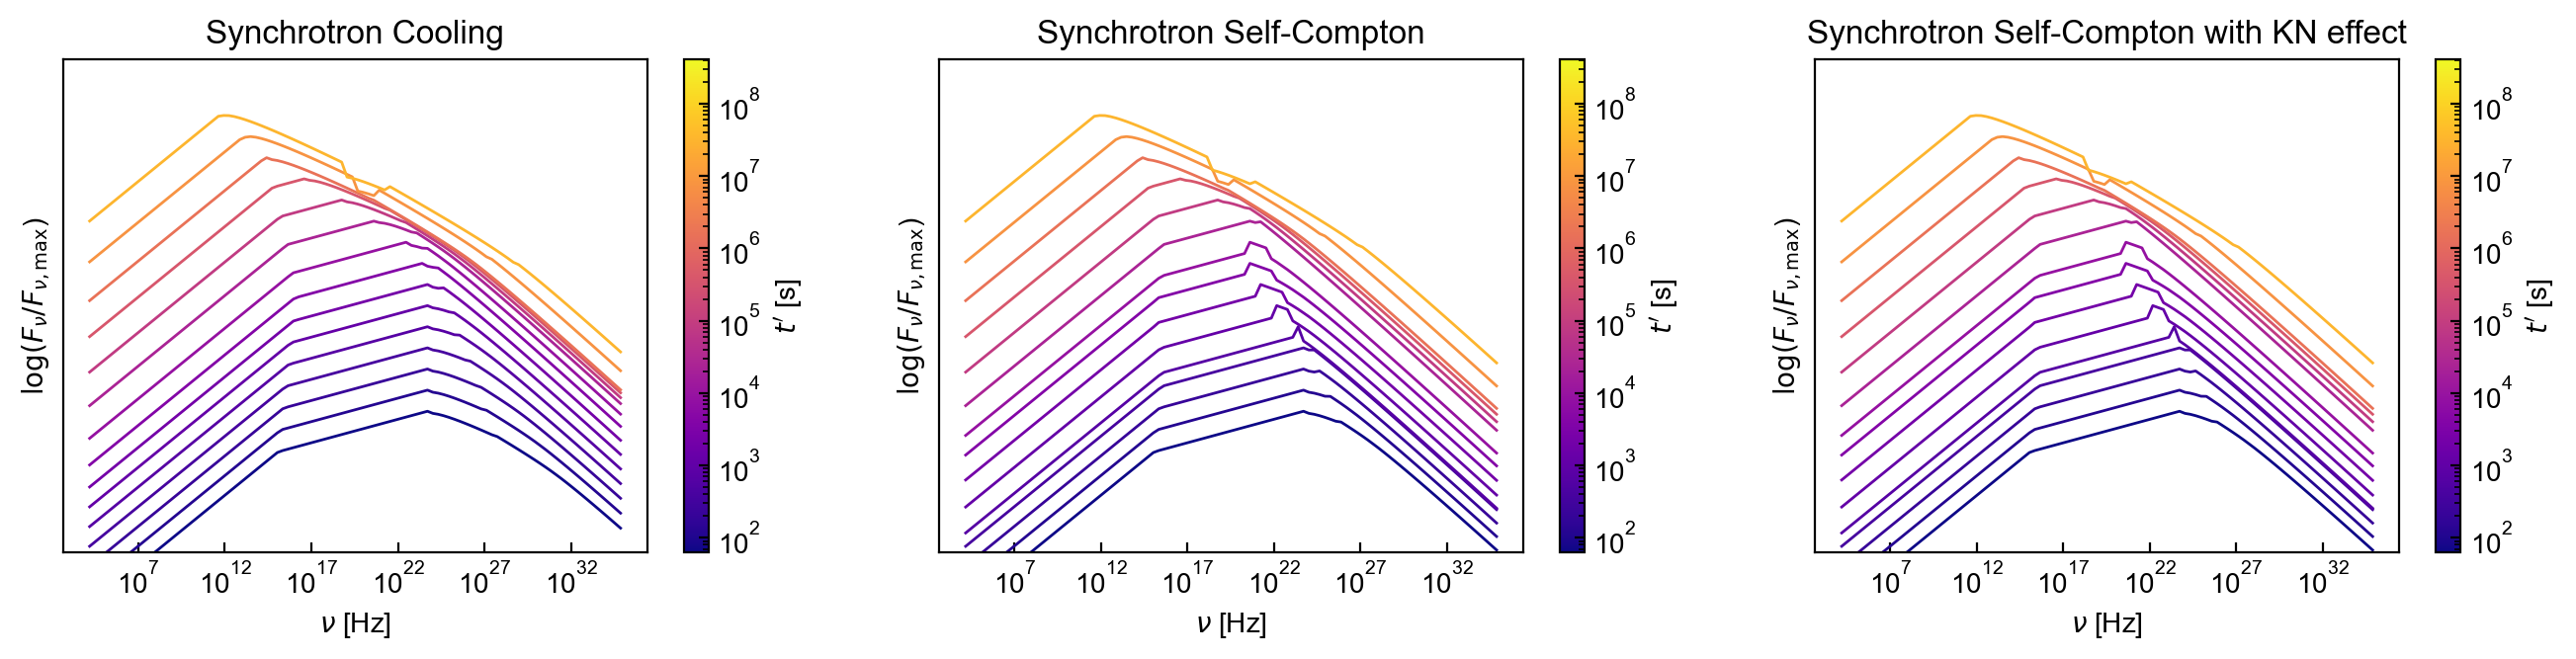

In [216]:
fig = plt.figure(figsize=(6*0.9*3, 3.6*0.9))
ax1 = fig.add_subplot(1,3,1)
full_spectrum(ax1, prefix,'t_com.txt','IC_spectrum.txt',1.5,'Synchrotron Cooling')
ax1.set_ylim(1e-10,1e25)

ax2 = fig.add_subplot(1,3,2)
full_spectrum(ax2, prefix,'t_com.txt','IC_IC_spectrum.txt',1.5,'Synchrotron Self-Compton')
ax2.set_ylim(1e-10,1e25)

ax2 = fig.add_subplot(1,3,3)
full_spectrum(ax2, prefix,'t_com.txt','IC_ICKN_spectrum.txt',1.5,'Synchrotron Self-Compton with KN effect')
ax2.set_ylim(1e-10,1e25)

plt.savefig(prefix+'IC_spectrum.pdf', dpi=300, bbox_inches='tight')

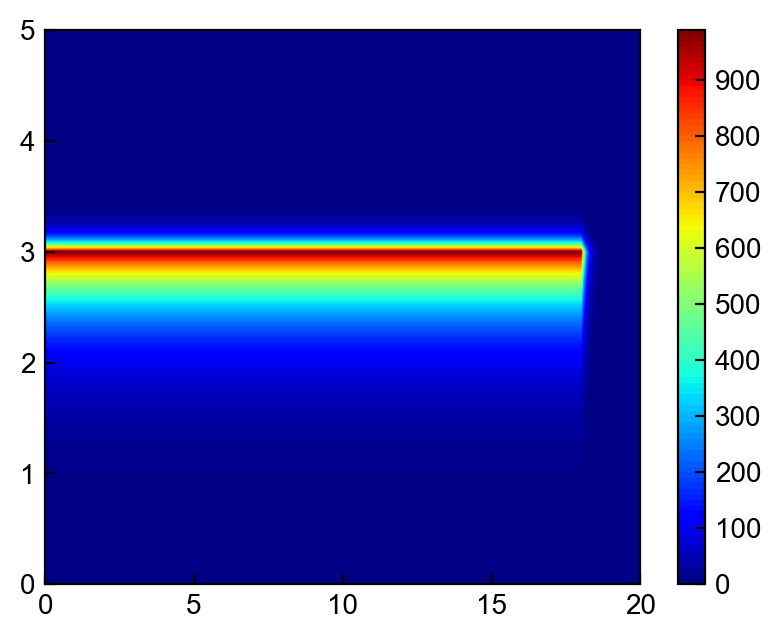

In [524]:

nu0 = np.logspace(0,20,500)
gamma = np.logspace(0,5,500)

n, g = np.meshgrid(nu0, gamma)
p = 2.2
N = np.zeros_like(n)
gp = 1000
gM = 1e5
N[g>=gp] = gp**3*(g[g>=gp]/gp)**(-p-1)
N[g<gp] = g[g<gp]**3 
N = N*np.exp(-g/gM)

F = np.zeros_like(n)
nu_p = 1e18
nu_M = 1e23
F[n >= nu_p] = nu_p**2*(n[n>=nu_p]/nu_p)**((-p)/2)
F[n < nu_p] = (n**2)[n<nu_p]
F = F*np.exp(-n/nu_M)
z = N*F/g/g/n/n#*(n/g*1e5)**-1
fig = plt.figure(figsize=(4.8, 3.6))
ax = fig.add_subplot(1,1,1)
cs = ax.contourf(np.log10(n),np.log10(g),(z), levels=100, cmap = 'jet')

#nu_ic = 1e12
#y = np.sqrt(nu_ic/4/nu0**2)
#ax.plot(np.log10(nu0),np.log10(y),c='black',lw=1)
cbar =plt.colorbar(cs)





In [525]:
ds = np.diff(g, axis=0)[:,0:-1]*np.diff(n, axis=1)[0:-1,:]

In [526]:
ic = np.logspace(5,32,1000)
g = g[0:-1,0:-1]
n = n[0:-1,0:-1]
z = z[0:-1,0:-1]
fs = []
for i in ic:
   select = (n*4*g*g > i) & (n<i)
   f = ((z*ds)[select]).sum()
   fs.append(f)


/var/folders/5k/755tmvm129l96bnf2zwbb07m0000gn/T/ipykernel_7602/3737262053.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(ic),np.log10(fs),c='black',lw=1)


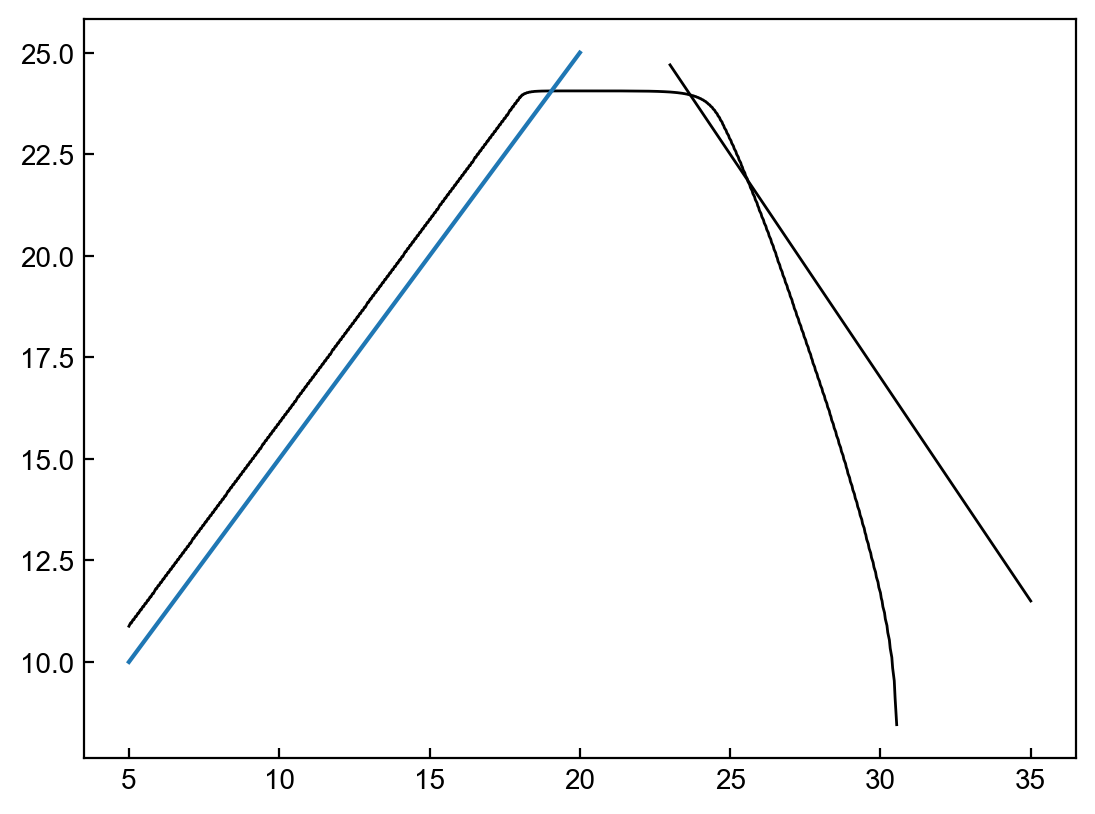

In [527]:
plt.plot(np.log10(ic),np.log10(fs),c='black',lw=1)
xx = np.logspace(23,35,100)
plt.plot(np.log10(xx),np.log10(1e50*xx**(-p/2)),c='black',lw=1)
yy = np.logspace(5,20,100)
plt.plot(np.log10(yy),np.log10(1e5*yy + np.log(yy)))